<div class="alert alert-block alert-success">
<h3><center style="line-height: 1">MSDS-422: Practical Machine Learning</center></h3>
<h1><center style="line-height: 1">Final Project: Group 5</center></h1>
<h2><center style="line-height: 1">Identifying Malware in Network Traffic with Supervised Learning</center></h2>

<b>Group 5</b>:
<ul>
    <li>Aishwarya Mathuria</li>
    <li>Tanmay Swami</li>
    <li>Akshaya Venkat Raman</li>
    <li>Yatika Taneja</li>
</ul>
</div>

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import glob
from datetime import datetime
import ipaddress
from collections import Counter
from scipy import stats
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import time

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Load Dataset</h1>
</div>

In [2]:
# Load all CSV files without any cleaning
print("Loading raw data")
csv_files = glob.glob('data/*.csv')
print(f"Found {len(csv_files)} CSV files:")
for file in sorted(csv_files):
    size_mb = Path(file).stat().st_size / (1024 * 1024)
    print(f"  - {file}: {size_mb:.2f} MB")

all_dataframes = []

for file in csv_files:
    try:
        print(f"Loading {file}...")
        df = pd.read_csv(file, sep='|')
        all_dataframes.append(df)
        print(f"  - Loaded {len(df)} records")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_dataframes:
    raise ValueError("No data files could be loaded")

df = pd.concat(all_dataframes, ignore_index=True)
print(f"\nCombined raw dataset shape: {df.shape}")

# Combine label and detailed-label
df['label'] = df['label'].astype(str)
df['detailed-label'] = df['detailed-label'].astype(str)
df['detailed-label'].replace('nan', pd.NA, inplace=True)
combined = df['label'] + ' ' + df['detailed-label']
df['label'] = combined.where(
    (df['label'] != 'Benign') & df['detailed-label'].notna(),
    df['label'])
df['label'] = df['label'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Drop detailed-label column
if 'detailed-label' in df.columns:
    df.drop(columns=['detailed-label'], inplace=True)
df.replace('-', pd.NA, inplace=True)

Loading raw data
Found 12 CSV files:
  - data/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv: 132.06 MB
  - data/CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv: 0.39 MB
  - data/CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv: 0.40 MB
  - data/CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv: 22.09 MB
  - data/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv: 2.85 MB
  - data/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv: 1243.76 MB
  - data/CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv: 0.54 MB
  - data/CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv: 0.03 MB
  - data/CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv: 498.91 MB
  - data/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv: 442.23 MB
  - data/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv: 1.27 MB
  - data/CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv: 886.22 MB
Loading data/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv...
  - Loaded 10447787 records
Loading data/CTU-IoT-Malware-Capture-3-1conn.log.labeled.c

In [3]:
print("\nUpdated label distribution:")
print(df['label'].value_counts())


Updated label distribution:
label
Malicious PartOfAHorizontalPortScan        10427048
Benign                                      8780158
Malicious DDoS                              5778154
Malicious C&C                                 15039
Malicious Attack                               8717
Malicious C&C HeartBeat                         940
Malicious C&C PartOfAHorizontalPortScan         888
Malicious C&C Torii                              30
Malicious C&C FileDownload                       26
Malicious FileDownload                            3
Name: count, dtype: int64


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Exploratory Data Analysis</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Basic dataset Information</h3>
</div>

In [4]:
print("\n")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Shape: {df.shape}")
df.info(memory_usage='deep')
print("\n")



Total records: 25011003
Total columns: 22
Shape: (25011003, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25011003 entries, 0 to 25011002
Data columns (total 22 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ts              float64
 1   uid             object 
 2   id.orig_h       object 
 3   id.orig_p       float64
 4   id.resp_h       object 
 5   id.resp_p       float64
 6   proto           object 
 7   service         object 
 8   duration        object 
 9   orig_bytes      object 
 10  resp_bytes      object 
 11  conn_state      object 
 12  local_orig      object 
 13  local_resp      object 
 14  missed_bytes    float64
 15  history         object 
 16  orig_pkts       float64
 17  orig_ip_bytes   float64
 18  resp_pkts       float64
 19  resp_ip_bytes   float64
 20  tunnel_parents  object 
 21  label           object 
dtypes: float64(8), object(14)
memory usage: 22.5 GB




In [5]:
numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
# Dropping some insignificant columns based on the value information
dropCols = ['uid', 'tunnel_parents', 'local_orig', 'local_resp', 'service', 'history', 'id.orig_h', 'id.resp_h', 'id.orig_h', 'id.resp_h']
df = df.drop(columns=dropCols)

In [7]:
df.head()

,ts,id.orig_p,id.resp_p,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1.545403e+09,59932.0,80.0,tcp,3.097754,0.0,0.0,S0,0.0,3.0,180.0,0.0,0.0,Malicious C&C
1,1.545403e+09,59932.0,80.0,tcp,NaN,NaN,NaN,S0,0.0,1.0,60.0,0.0,0.0,Malicious C&C
2,1.545403e+09,59932.0,80.0,tcp,NaN,NaN,NaN,S0,0.0,1.0,60.0,0.0,0.0,Malicious C&C
3,1.545403e+09,35883.0,53.0,udp,5.005148,78.0,0.0,S0,0.0,2.0,134.0,0.0,0.0,Benign
4,1.545403e+09,43531.0,53.0,udp,5.005145,78.0,0.0,S0,0.0,2.0,134.0,0.0,0.0,Benign


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Columns</h3>
</div>

In [8]:
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

Columns:
    1. ts
    2. id.orig_p
    3. id.resp_p
    4. proto
    5. duration
    6. orig_bytes
    7. resp_bytes
    8. conn_state
    9. missed_bytes
   10. orig_pkts
   11. orig_ip_bytes
   12. resp_pkts
   13. resp_ip_bytes
   14. label


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Data types</h3>
</div>

In [9]:
print(df.dtypes.value_counts())

float64    11
object      3
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing values</h3>
</div>

,MissingValues,Percent
duration,15272073,61.06
orig_bytes,15272073,61.06
resp_bytes,15272073,61.06


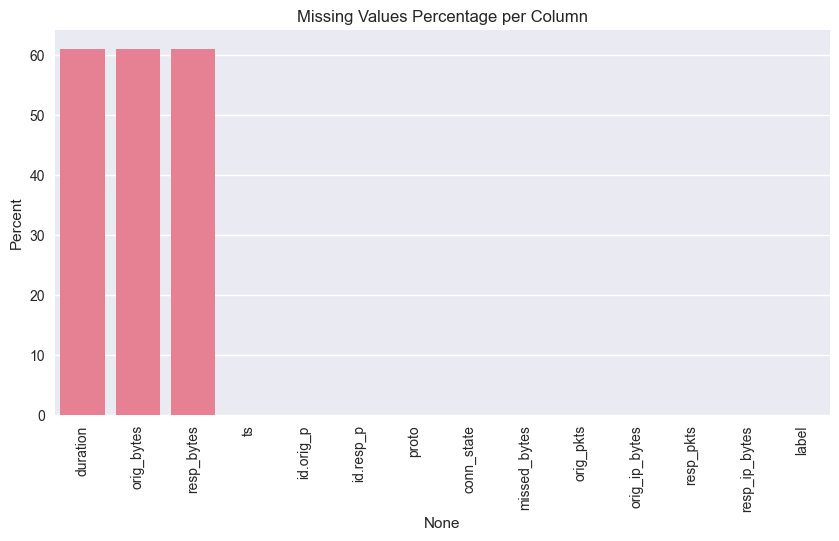

In [10]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'MissingValues': missing, 'Percent': missing_percent})
display(missing_df[missing_df.MissingValues > 0])

# Visualize missing values
plt.figure(figsize=(10,5))
sns.barplot(x=missing_df.index, y=missing_df['Percent'])
plt.xticks(rotation=90)
plt.title("Missing Values Percentage per Column")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value Distribution</h3>
</div>

label
Malicious PartOfAHorizontalPortScan        10427048
Benign                                      8780158
Malicious DDoS                              5778154
Malicious C&C                                 15039
Malicious Attack                               8717
Malicious C&C HeartBeat                         940
Malicious C&C PartOfAHorizontalPortScan         888
Malicious C&C Torii                              30
Malicious C&C FileDownload                       26
Malicious FileDownload                            3
Name: count, dtype: int64


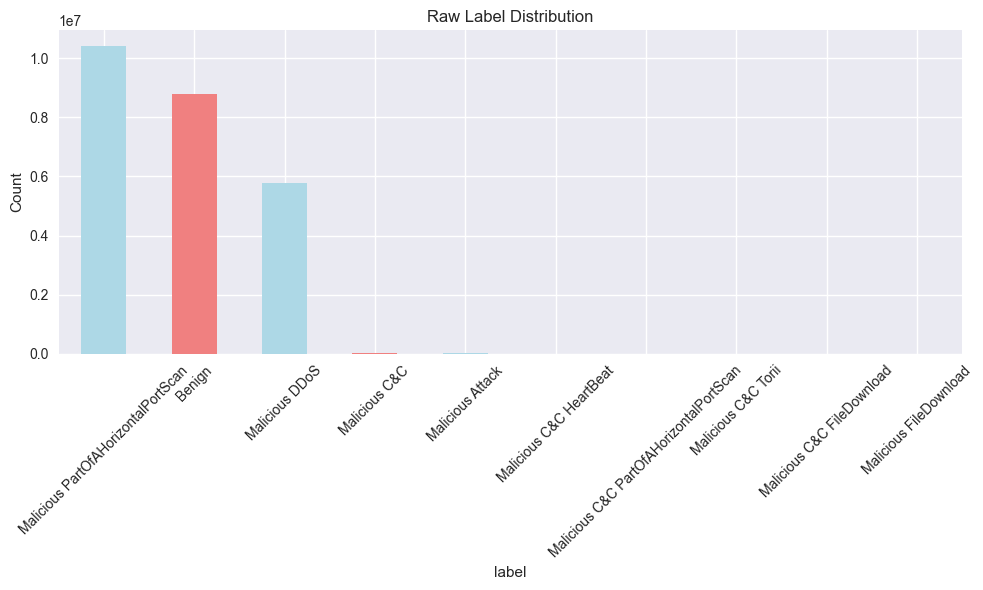

In [11]:
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Raw Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Histograms for numerical features</h3>
</div>

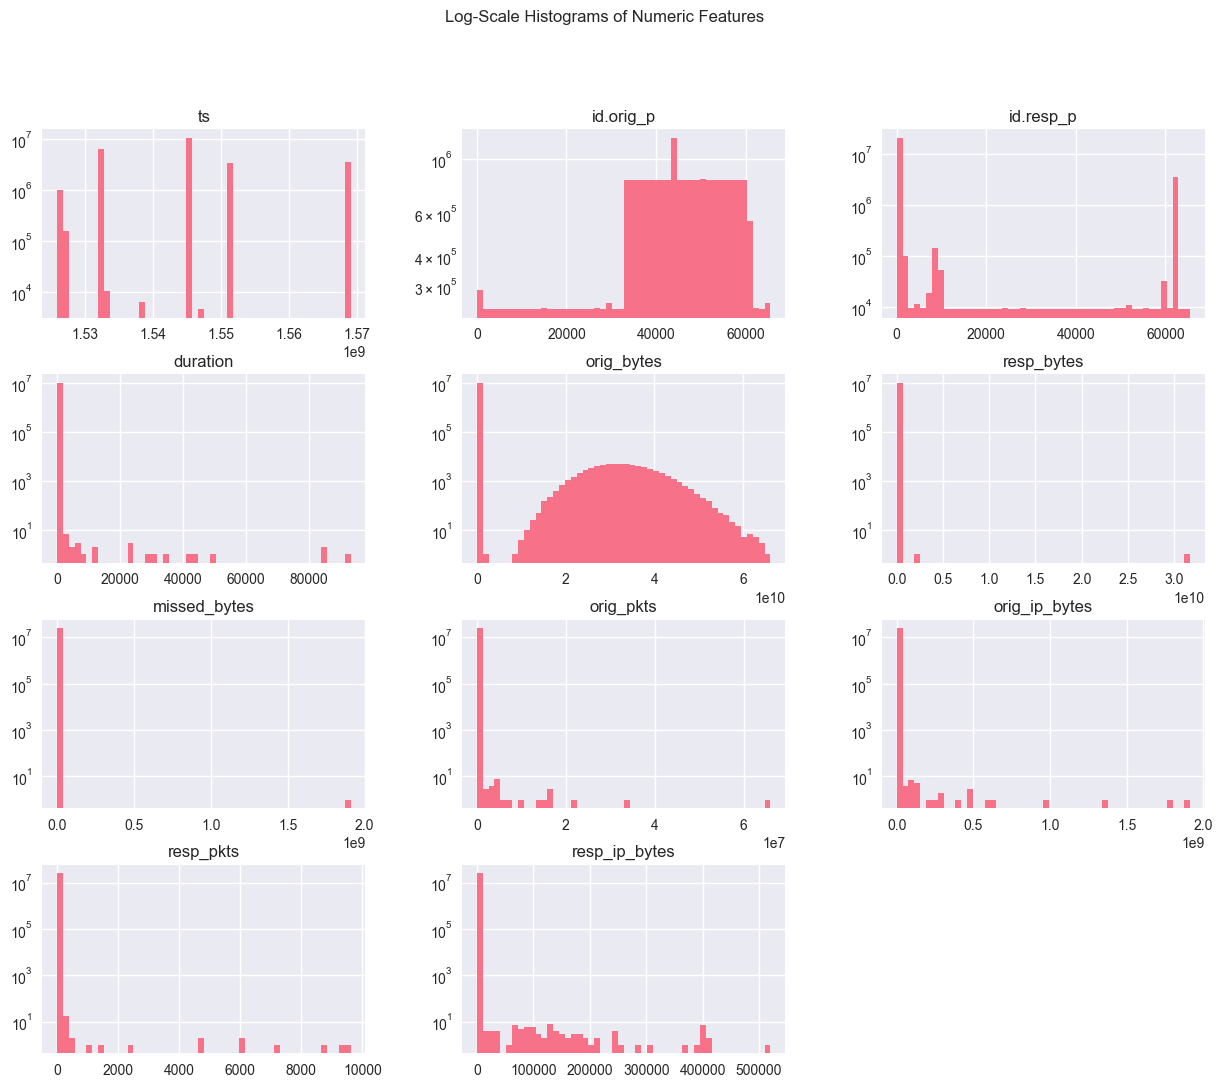

In [12]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15, 12), bins=50, log=True)
plt.suptitle("Log-Scale Histograms of Numeric Features")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation Heatmap</h3>
</div>

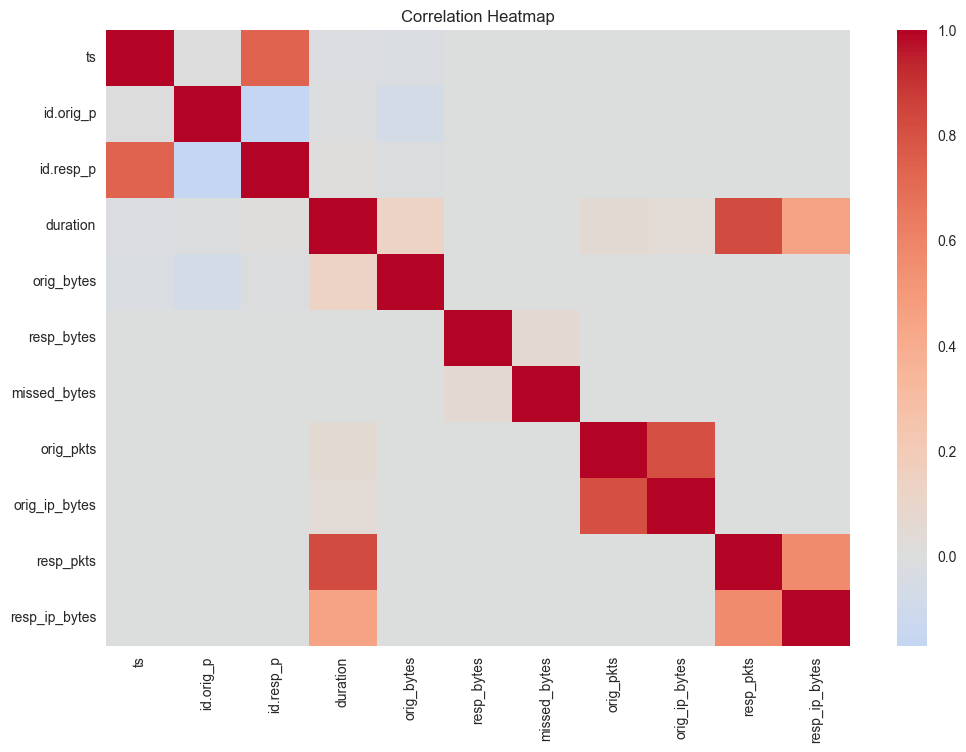

In [13]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Boxplots by Label</h3>
</div>

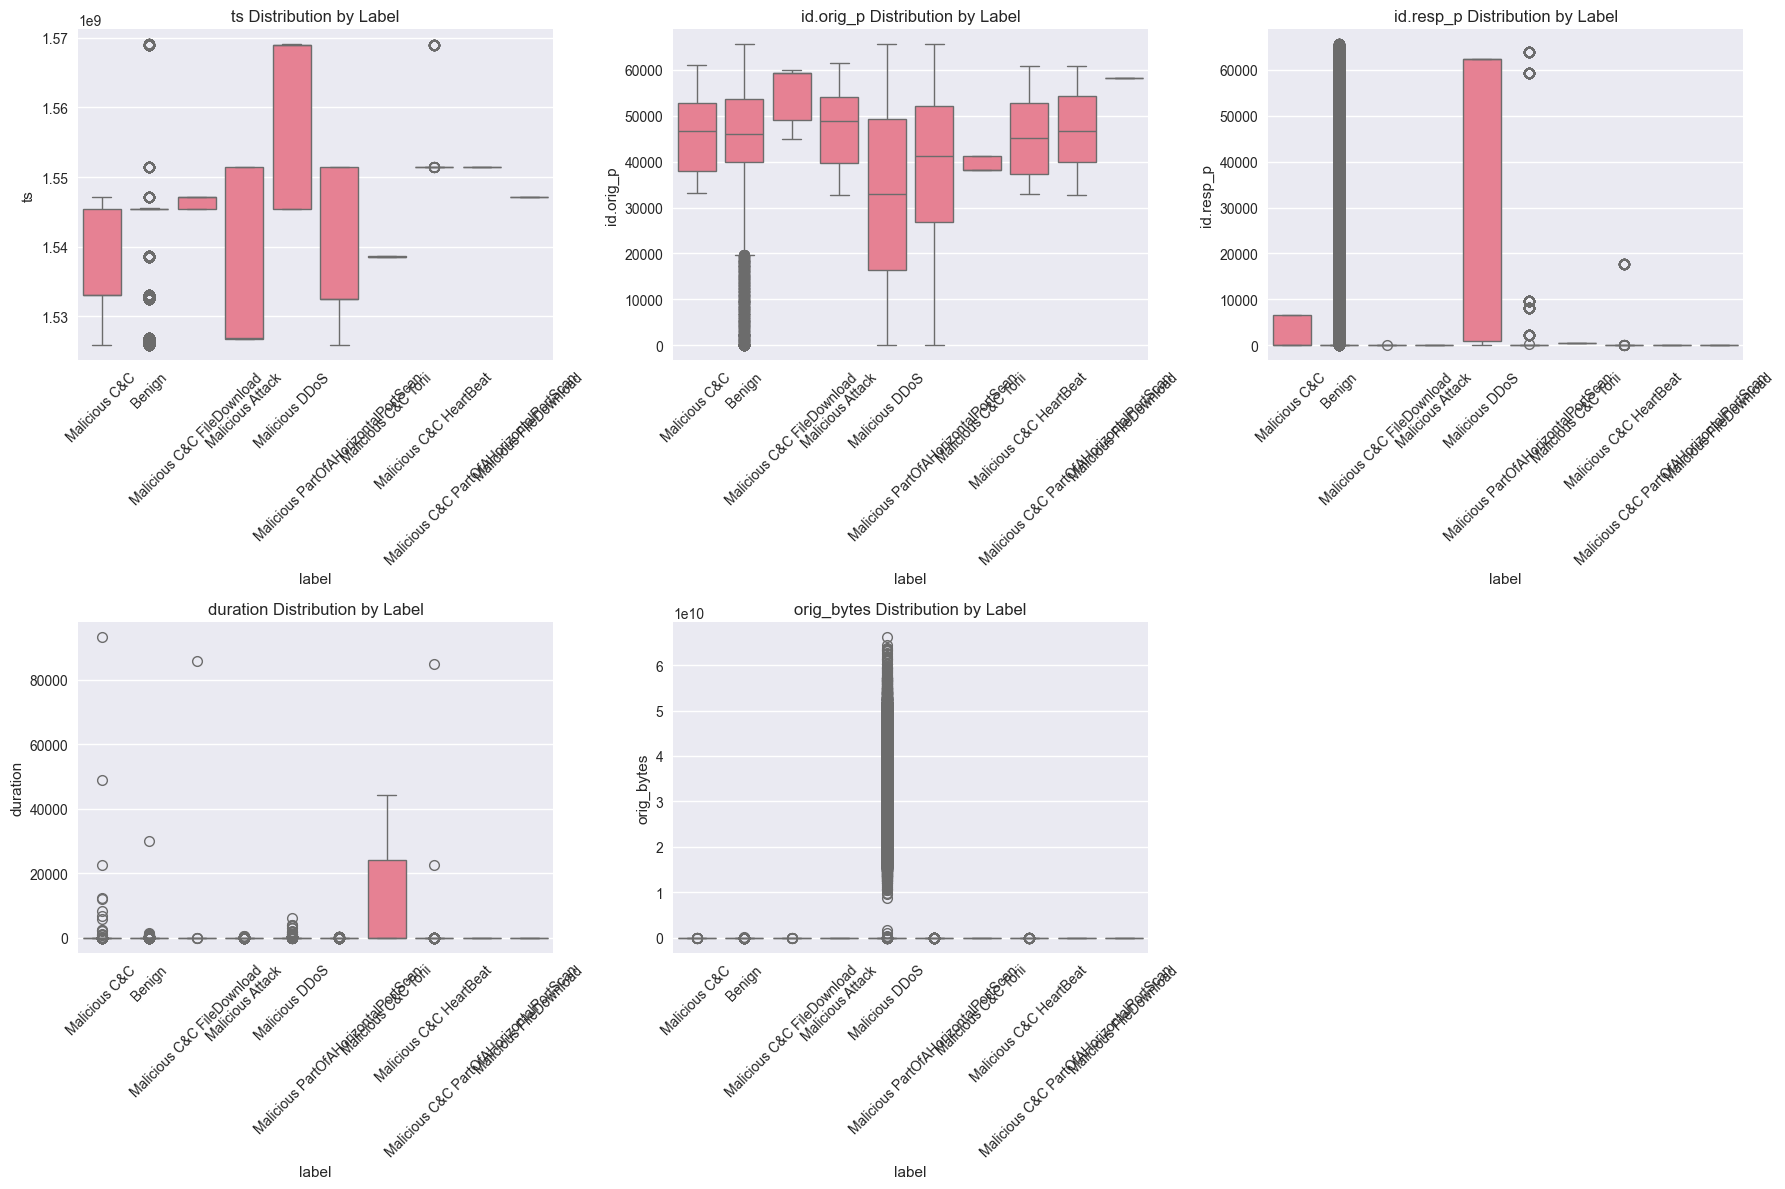

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:5]):  # first 5 numeric features
    sns.boxplot(x='label', y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} Distribution by Label")
    axes[i].tick_params(axis='x', rotation=45)

axes[5].set_visible(False)

plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Outlier detection</h3>
</div>

In [15]:
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outlier_count} outliers")


ts: 0 outliers
id.orig_p: 769075 outliers
id.resp_p: 5344827 outliers
duration: 3466067 outliers
orig_bytes: 120087 outliers
resp_bytes: 36007 outliers
missed_bytes: 43 outliers
orig_pkts: 180286 outliers
orig_ip_bytes: 93152 outliers
resp_pkts: 54629 outliers
resp_ip_bytes: 54629 outliers


<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Exploratory Data Analysis Observation</h2>
    <h3>1. Target variable</h3>
    <p>
        There are 2 level label columns available - <strong>“label”</strong> and <strong>“detailed-label”</strong>. The two have been concatenated into a single field <strong>"label"</strong> to create a multi class prediction model.
    </p>
    <h3>2. Missing Data Patterns</h3>
    <ul>
        <li><strong>Critical Finding:</strong> 61.06% missing values in duration, orig_bytes, and resp_bytes (15,272,073 records)</li>
        <li>This pattern likely indicates <strong>incomplete network connections</strong> - potentially scanning attempts or failed connections</li>
        <li>Missing data distribution suggests systematic patterns rather than random occurrence</li>
    </ul>
    <h3>3. Network Traffic Characteristics</h3>
    <ul>
        <li><strong>TCP</strong> and <strong>UDP</strong> protocols are dominant with distinct behavioral patterns</li>
        <li>There is a mix of well-known ports (0-1023), registered ports (1024-49151), and dynamic ports (49152-65535). There is a potential to group this into more genric terms.</li>
        <li>Various connection states including <strong>S0 (rejected), SF (normal),</strong> indicating different connection behaviors</li>
        <li>Traffic distributed across hours and days, revealing potential attack timing signatures</li>
    </ul>
    <h3>4. Data Quality Assessment</h3>
    <ul>
        <li>There are no negative values detected in numerical columns indicating good data integrity</li>
        <li>Significant outliers are present in network metrics, requiring careful handling</li>
        <li>There is a strong relationships between traffic volume metrics and packet counts</li>
        <li>Multi class classification between <strong>'Benign', 'Malicious C&C' etc.</strong> for traffic will be required.</li>
    </ul>
    <h3>5. Feature Engineering Opportunities</h3>
    <ul>
        <li>Timestamps can be used to engineer more generic and significant features like hour and day_of_week to classify network patterns.</li>
        <li>Creating meaningful port categories for behavioral analysis can help get a more generic prediction model.</li>
        <li>Identified potential for ratio-based features (bytes per packet, packets per second) that can act as a strong features for prediction.</li>
        <li>High missing rates may serve as strong predictive features</li>
    </ul>
    <h3>6. Implications for Model Development</h3>
    <ul>
        <li>Missing value patterns appear to be <strong>highly indicative of malicious behavior</strong></li>
        <li>Feature engineering can be used to convert some values like timestamp, packet info into a more significant predicion features.</li>
        <li>There are a lot of categorical columns that can be properly encoded to ensure optimal model performance</li>
    </ul>
</div>

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Data Cleaning and Preparation</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling missing values</h3>
</div>

In [16]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [17]:
for col in numeric_cols:
    if col in df.columns:
        print(f"Converting {col} to numeric...")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        missing_after = df[col].isnull().sum()
        print(f"    Missing values: {missing_before} -> {missing_after}")

Converting ts to numeric...
    Missing values: 0 -> 0
Converting id.orig_p to numeric...
    Missing values: 0 -> 0
Converting id.resp_p to numeric...
    Missing values: 0 -> 0
Converting duration to numeric...
    Missing values: 15272073 -> 0
Converting orig_bytes to numeric...
    Missing values: 15272073 -> 0
Converting resp_bytes to numeric...
    Missing values: 15272073 -> 0
Converting missed_bytes to numeric...
    Missing values: 0 -> 0
Converting orig_pkts to numeric...
    Missing values: 0 -> 0
Converting orig_ip_bytes to numeric...
    Missing values: 0 -> 0
Converting resp_pkts to numeric...
    Missing values: 0 -> 0
Converting resp_ip_bytes to numeric...
    Missing values: 0 -> 0


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Feature Engineering</h3>
    <p>To uncover hidden behavioral patterns in network traffic that raw totals (bytes, packets, duration) cannot show, we will be enngineering features BytesPerPacket and PacketsPerSecond reveal packet size anomalies and traffic burst intensity for better attack detection.</p>
</div>

In [18]:
df['TotalBytes'] = df['orig_bytes'].fillna(0) + df['resp_bytes'].fillna(0)
df['TotalPackets'] = df['orig_pkts'].fillna(0) + df['resp_pkts'].fillna(0)

df['bytes_per_pkt'] = np.where(df['TotalPackets'] > 0, df['TotalBytes'] / df['TotalPackets'], 0)
df['pkt_per_sec'] = np.where(df['duration'] > 0, df['TotalPackets'] / df['duration'], 0)

df.drop(['TotalBytes', 'TotalPackets'], axis=1, inplace=True)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Convert timestamp to better fearure components</h3>
    <p>Since timestamp is a very uique typr of feature that will not add much value to the overall prediction, we cannot use that. However, the information about the time of day and day of week the attack happened will be helpful predictors. We will be adding hour and day_of_week features to create strong predictors out of this.</p>
</div>

In [19]:
print("Converting timestamps")
df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
invalid_timestamps = df['timestamp'].isnull().sum()
print(f"    Invalid timestamps: {invalid_timestamps}")

# Adding temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
print("Added hour and day_of_week features")

Converting timestamps
    Invalid timestamps: 0
Added hour and day_of_week features


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling connection ports</h3>
    <p>We will categorize origin and response ports into well_known (0–1024), registered (1025–49151), and dynamic (49152–65535) ranges to transform raw port numbers into meaningful service categories. This is done because raw port values are high-cardinality and difficult for models to interpret directly, while grouped categories reveal the purpose and behavior of traffic—for example, repeated connections on well-known ports may indicate scanning, while unusual activity on dynamic ports could suggest malicious use. By converting ports into these categories, we simplify feature space, reduce noise, and make it easier for machine learning models to detect patterns of attacks and abnormal network behaviors.</p>
</div>

In [20]:
# Categorize ports into common service types
def categorize_port(port):
    try:
        port = int(port)
        if port <= 1024:
            return 'well_known'
        elif port <= 49151:
            return 'registered'
        else:
            return 'dynamic'
    except:
        return 'unknown'

print("Categorizing origin ports...")
df['orig_port_category'] = df['id.orig_p'].apply(categorize_port)
    
print("Categorizing response ports...")
df['resp_port_category'] = df['id.resp_p'].apply(categorize_port)

Categorizing origin ports...
Categorizing response ports...


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Drop insignificant columns and high cardinality columns</h3>
</div>

In [21]:
df.columns

Index(['ts', 'id.orig_p', 'id.resp_p', 'proto', 'duration', 'orig_bytes',
       'resp_bytes', 'conn_state', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label', 'bytes_per_pkt',
       'pkt_per_sec', 'timestamp', 'hour', 'day_of_week', 'orig_port_category',
       'resp_port_category'],
      dtype='object')

In [22]:
cols_to_drop = []
for col in df.columns:
    if df[col].nunique() < 2:
        cols_to_drop.append(col)
    elif df[col].nunique() == len(df):
        cols_to_drop.append(col)
print(cols_to_drop)
df.drop(columns=cols_to_drop, inplace=True)

['ts', 'timestamp']


In [23]:
categorical_cols = df.drop(columns= 'label').select_dtypes(include=['object']).columns

print(df.select_dtypes(exclude=['object']).columns.tolist())
print("-" * 20)
print(categorical_cols)

['id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'bytes_per_pkt', 'pkt_per_sec', 'hour']
--------------------
Index(['proto', 'conn_state', 'day_of_week', 'orig_port_category',
       'resp_port_category'],
      dtype='object')


In [24]:
df[df.select_dtypes(exclude=['object']).columns.tolist() + list(categorical_cols)].head()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,bytes_per_pkt,pkt_per_sec,hour,proto,conn_state,day_of_week,orig_port_category,resp_port_category
0,59932.0,80.0,3.097754,0.0,0.0,0.0,3.0,180.0,0.0,0.0,0.0,0.968444,14,tcp,S0,Friday,dynamic,well_known
1,59932.0,80.0,0.000000,0.0,0.0,0.0,1.0,60.0,0.0,0.0,0.0,0.000000,14,tcp,S0,Friday,dynamic,well_known
2,59932.0,80.0,0.000000,0.0,0.0,0.0,1.0,60.0,0.0,0.0,0.0,0.000000,14,tcp,S0,Friday,dynamic,well_known
3,35883.0,53.0,5.005148,78.0,0.0,0.0,2.0,134.0,0.0,0.0,39.0,0.399589,14,udp,S0,Friday,registered,well_known
4,43531.0,53.0,5.005145,78.0,0.0,0.0,2.0,134.0,0.0,0.0,39.0,0.399589,14,udp,S0,Friday,registered,well_known


In [25]:
for col in df[categorical_cols]:
    print(f"{col}: {df[col].nunique()} unique values : {df[col].unique()[:5]}...")

proto: 3 unique values : ['tcp' 'udp' 'icmp']...
conn_state: 13 unique values : ['S0' 'SF' 'REJ' 'OTH' 'RSTO']...
day_of_week: 7 unique values : ['Friday' 'Saturday' 'Sunday' 'Monday' 'Wednesday']...
orig_port_category: 3 unique values : ['dynamic' 'registered' 'well_known']...
resp_port_category: 3 unique values : ['well_known' 'dynamic' 'registered']...


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Visualizing engineered and existing categorical columns</h3>
</div>

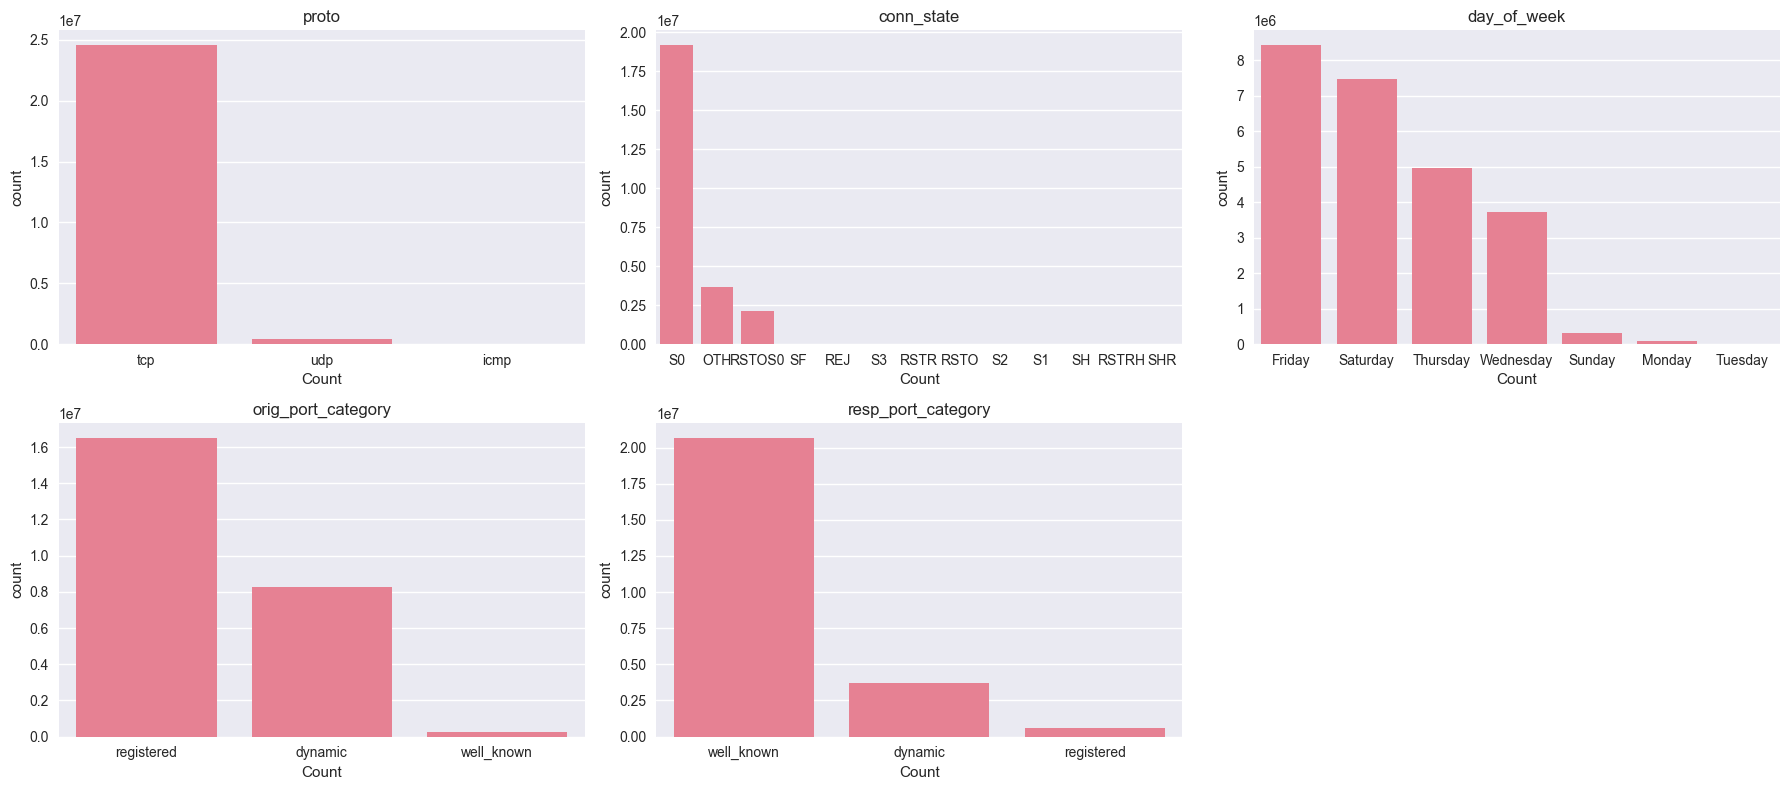

In [26]:
cat_cols = ['proto', 'conn_state', 'day_of_week', 'orig_port_category', 'resp_port_category']

n_cols = 3  
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(6*n_cols, 4*n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    if col == 'history':
        top_hist = df[col].value_counts().nlargest(20).index
        plot_data = df[df[col].isin(top_hist)]
        sns.countplot(y=col, data=plot_data, order=top_hist)
        plt.title(f"{col} (Top 20)")
    else:
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(col)
    plt.xlabel("Count")
    plt.tight_layout()

plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling duplicates</h3>
</div>

In [27]:
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_after = df.duplicated().sum()
print(f"Removed {duplicates_before - duplicates_after} duplicate rows")

Removed 12943478 duplicate rows


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Label Encoding</h3>
</div>

In [28]:
encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    print(f"Encoded column '{col}' with {len(le.classes_)} classes")

Encoded column 'proto' with 3 classes
Encoded column 'conn_state' with 13 classes
Encoded column 'label' with 10 classes
Encoded column 'day_of_week' with 7 classes
Encoded column 'orig_port_category' with 3 classes
Encoded column 'resp_port_category' with 3 classes


<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Data Cleaning and Preparation Observations</h2>
    <h3>1. Feature Engineering</h3>
    <ul>
        <li>Extracted <strong>hour</strong> and <strong>day_of_week</strong> from timestamp for predicting behavioral patterns in network traffic</li>
        <li>Classified ports into <strong>well_known (0-1023), registered (1024-49151), and dynamic (49152-65535)</strong> categories</li>
        <li>Use feature engineering to more generic features for better prediction.</li>
        <li>Filled NaN values with 0, preserving the informative pattern of missingness</li>
    </ul>
    <h3>2. Categorical Data Observations</h3>
    <ul>
        <li>From the visuals, <strong>TCP</strong> and <strong>UDP</strong> dominate the traffic patterns with distinct characteristics</li>
        <li><strong>S0</strong> (rejected connections) prevalent, indicating potential scanning/attack behavior</li>
        <li>Traffic distributed across different <strong>hours</strong> and <strong>days of week</strong> created via feature engineering is giving a good prediction criteria.</li>
        <li>There is a balanced distribution across well-known, registered, and dynamic port ranges</li>
    </ul>
    <h3>3. Label Encoding Results</h3>
    <ul>
        <li>All categorical columns successfully transformed to numerical format for making them part of prediction.</li>
        <li>Maintained original categorical relationships through systematic encoding</li>
        <li>Dataset is now compatible with machine learning algorithms requiring numerical input</li>
        <li>Preserved encoders for potential inverse transformation and model deployment</li>
    </ul>
    <h3>4. Data Quality Validation</h3>
    <ul>
        <li>Successfully eliminated all missing values through strategic imputation</li>
        <li>Confirmed absence of negative values in numerical columns</li>
        <li>Maintained original data relationships while preparing for modeling</li>
        <li>All features now in appropriate format for analysis and modeling</li>
    </ul>
</div>

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Post Cleanup Analysis and Processing</h1>
</div>

In [29]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing Values</h3>
</div>

In [30]:
missing_after = df.isnull().sum()
print("Missing values after cleanup:")
print(missing_after[missing_after > 0])

Missing values after cleanup:
Series([], dtype: int64)


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Negative values check</h3>
</div>

In [31]:
for col in numeric_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} negative values")
        else:
            print(f"{col}: No negative values")

id.orig_p: No negative values
id.resp_p: No negative values
proto: No negative values
duration: No negative values
orig_bytes: No negative values
resp_bytes: No negative values
conn_state: No negative values
missed_bytes: No negative values
orig_pkts: No negative values
orig_ip_bytes: No negative values
resp_pkts: No negative values
resp_ip_bytes: No negative values
label: No negative values
bytes_per_pkt: No negative values
pkt_per_sec: No negative values
day_of_week: No negative values
orig_port_category: No negative values
resp_port_category: No negative values


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value distribution</h3>
</div>

label
9    5011429
0    4921193
7    2113498
2      10899
1       8717
4        940
5        797
3         26
6         23
8          3
Name: count, dtype: int64


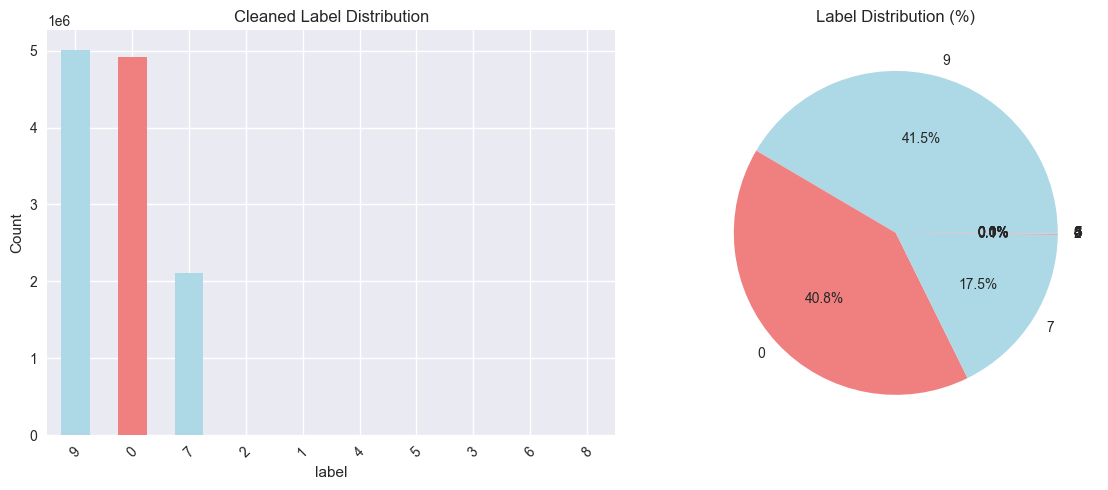

Class imbalance ratio: 0.00


In [32]:
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Cleaned Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution (%)')
plt.tight_layout()
plt.savefig('cleaned_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class imbalance ratio: {label_counts[1] / label_counts[0]:.2f}")

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation analysis</h3>
</div>

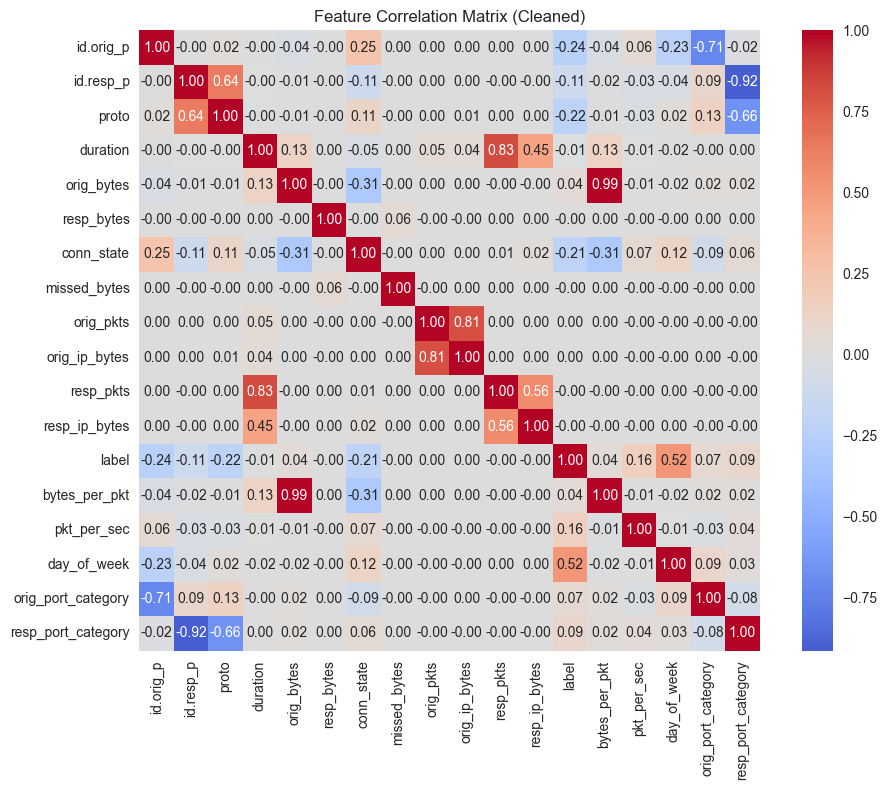

In [33]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Cleaned)')
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Scaling and Train-Test Split</h3>
</div>

In [34]:
X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

print("\n\nBefore ROS shape:", X_train.shape)
print("Class distribution:", y_train.value_counts())

print("\n\nAfter ROS shape:", X_res.shape)
print("Class distribution:", y_res.value_counts())



Before ROS shape: (9654020, 17)
Class distribution: label
9    4008764
0    3936936
7    1691226
2       8681
1       7001
4        749
5        623
3         21
6         16
8          3
Name: count, dtype: int64


After ROS shape: (40087640, 17)
Class distribution: label
9    4008764
0    4008764
7    4008764
1    4008764
2    4008764
5    4008764
4    4008764
6    4008764
3    4008764
8    4008764
Name: count, dtype: int64


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

sample_size = min(1_000_000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)

X_sample = X_train_scaled[sample_indices]
y_sample = y_res.iloc[sample_indices].reset_index(drop=True)

<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Post Cleanup Analysis and Processing Observations</h2>
    <h3>1. Data Integrity and Cleanup</h3>
    <ul>
        <li><strong>All missing values were eliminated</strong>, confirmed by a final null check showing <strong>0 NaNs</strong>. Models will not face imputation bias, and computations like scaling or encoding will run without errors.</li>
        <li><strong>Negative values were not present</strong> in numeric columns, ensuring data validity for traffic-related features such as <strong>duration</strong> and <strong>byte counts</strong>. This Prevents logical inconsistencies in features that represent counts or time.</li>
        <li><strong>Outlier analysis revealed extremely skewed distributions</strong>:
            <ul>
                <li><strong>id.resp_p:</strong> 5,344,827 extreme values</li>
                <li><strong>duration:</strong> 3,466,067 extreme values</li>
                <li><strong>id.orig_p:</strong> 769,075 extreme values</li>
            </ul>
            These were <strong>retained intentionally</strong> because in network traffic, extreme spikes often indicate malicious activity (e.g., port scans or DDoS attempts). This preserves attack patterns critical for accurate anomaly detection.
        </li>
    </ul>
    <h3>2. Feature Engineering and Transformation</h3>
    <ul>
        <li><strong>Time-based features</strong> (hour, day_of_week) were extracted from timestamps to capture periodic attack patterns. This allows models to learn daily and hourly trends of network anomalies.</li>
        <li><strong>Port categorization</strong> was implemented for <strong>origin</strong> and <strong>response ports</strong>:
            <ul>
                <li>0–1023 -> Well-known</li>
                <li>1024–49151 -> Registered</li>
                <li>49152–65535 -> Dynamic</li>
            </ul>
            <p>This step simplifies learning for models by grouping thousands of ports into meaningful behavior categories.</p>
        </li>
        <li>Feature engineering added more meaningful features using the high cardinality and low corelation values. These features are shown to have a strong correlation with the target label (e.g. day of week has a correlation factor of 0.47 with label) which improves the model’s ability to detect subtle malicious patterns.</li>
    </ul>
    <h3>3. Categorical Encoding and Preparation for Modeling</h3>
    <ul>
        <li>Categorical variables (<strong>proto, conn_state, label</strong>) and engineered port categories were <strong>encoded numerically</strong>. The dataset is now fully numeric and compatible with ML algorithms like logistic regression, XGBoost, and tree ensembles.</li>
        <li><strong>Encoding preserved category relationships</strong>, ensuring that model interpretation and inverse transformation (for deployment) remain possible.</li>
    </ul>
    <h3>4. Class Distribution and Its Implications</h3>
    <ul>
        <li>The dataset is <strong>highly imbalanced</strong>:
            <ul>
                <li><strong>Malicious PartOfAHorizontalPortScan</strong> -> 10,427,048 records</li>
                <li><strong>Benign</strong> -> 8,780,158 records</li>
                <li><strong>Malicious DDoS</strong> -> 5,778,154 records</li>
                <li><strong>Minority classes (e.g., FileDownload)</strong> -> as low as 3 records</li>
            </ul>
            <p>Models trained without adjustment will be biased towards dominant classes. We have used RandomOverSampler to handle this imbalance to prepare the training dataset for the model training.</p>
        </li>
        <li>This distribution reflects <strong>real-world attack skewness</strong>, where certain attack types dominate traffic logs.
        </li>
    </ul>
    <h3>5. Dataset Readiness for Modeling</h3>
    <ul>
        <li>All features are now <strong>clean, numeric, and logically structured</strong> for machine learning.</li>
        <li>Feature engineering ensures the model can leverage <strong>time-of-attack and port behavior</strong> as predictive signals.</li>
        <li>Dataset is now fully prepared for <strong>cross-validation and supervised model training</strong>.</li>
        <li>Standardized all features to have mean 0 and standard deviation 1 using <strong>StandardScaler</strong> from the training data. This will ensure all features contribute equally.</li>
        <li>We scale all features to standardize their values and then sample up to <strong>1,000,000</strong> rows to create a manageable training subset. This speeds up model training and tuning while keeping the sample large enough to capture key traffic and attack patterns.</li>
    </ul>
</div>


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Cross Validation</h1>
    <ul>
        <li>Logistic Regression</li>
        <li>XGBoost</li>
        <li>LiteGBM</li>
        <li>CatBoost</li>
        <li>HistGradientBoosting</li>
        <li>CatBoost</li>
        <li>ExtraTrees</li>
        <li>SGDClassifier</li>
    </ul>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Logistic Regression</h3>
</div>

In [37]:
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nTraining Logistic Regression ...")
start = time.time()

log_reg = LogisticRegression(
    solver='saga',
    max_iter=200,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

scores = cross_val_score(log_reg, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'Logistic Regression',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results)


Training Logistic Regression ...


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,Model,Mean F1-Score,Std Dev,Time (sec)
0,Logistic Regression,0.761067,0.017151,127.595043


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>XGBoost</h3>
</div>

In [38]:
print("\nTraining XGBoost ...")
start = time.time()

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.3,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

scores = cross_val_score(xgb_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'XGBoost',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training XGBoost ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987412,0.000183,32.698874
0,Logistic Regression,0.761067,0.017151,127.595043


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>LiteGBM</h3>
</div>

In [39]:
print("\nTraining LightGBM ...")
start = time.time()

lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.3,
    subsample=0.7,
    colsample_bytree=0.7,
    num_leaves=15,
    max_bin=127,
    force_col_wise=True,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(lgbm_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'LightGBM',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training LightGBM ...
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 17
[LightGBM] [Info] Total Bins 1266
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 17
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 17
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 17
[LightGBM] [Info] Start training from score -2.300113
[LightGBM] [Info] Start training from score -2.303485
[LightGBM] [Info] Start training from score -2.300737
[LightGBM] [Info] Start training from score -2.302748
[LightGBM] [Info] Start training from score -2.305627
[LightGBM] [Info] Start training from score -2.303373
[LightGBM] [Info] Start training from score -2.301985
[LightGBM] [Info] Start training from score -2.300674
[LightGBM] [Info] Start training 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987412,0.000183,32.698874
0,Logistic Regression,0.761067,0.017151,127.595043
2,LightGBM,0.224413,0.081855,27.294723


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>CatBoost</h3>
</div>

In [40]:
print("\nTraining CatBoost ...")
start = time.time()

catbm_model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.2,
        depth=4,
        eval_metric='MultiClass',
        loss_function='MultiClass',
        task_type='CPU',
        verbose=50,
        random_seed=42
    )

scores = cross_val_score(catbm_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

end = time.time()
elapsed = end - start

results.append({
    'Model': 'CatBoost',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training CatBoost ...
0:	learn: 1.4143230	total: 959ms	remaining: 3m 10s
0:	learn: 1.4143979	total: 1.13s	remaining: 3m 45s
0:	learn: 1.4146906	total: 1.11s	remaining: 3m 41s
0:	learn: 1.4138684	total: 1.09s	remaining: 3m 36s
0:	learn: 1.4143270	total: 923ms	remaining: 3m 3s
50:	learn: 0.0806682	total: 27.2s	remaining: 1m 19s
50:	learn: 0.0833710	total: 27.5s	remaining: 1m 20s
50:	learn: 0.0801761	total: 28.1s	remaining: 1m 22s
50:	learn: 0.0824527	total: 27.8s	remaining: 1m 21s
50:	learn: 0.0818728	total: 28.7s	remaining: 1m 23s
100:	learn: 0.0569356	total: 53.2s	remaining: 52.1s
100:	learn: 0.0574616	total: 53.6s	remaining: 52.5s
100:	learn: 0.0559514	total: 53.8s	remaining: 52.7s
100:	learn: 0.0571613	total: 53.9s	remaining: 52.9s
100:	learn: 0.0568312	total: 54.4s	remaining: 53.3s
150:	learn: 0.0496863	total: 1m 20s	remaining: 26.1s
150:	learn: 0.0498357	total: 1m 21s	remaining: 26.3s
150:	learn: 0.0502079	total: 1m 21s	remaining: 26.3s
150:	learn: 0.0505303	total: 1m 21s	remainin

,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987412,0.000183,32.698874
3,CatBoost,0.985238,0.000343,110.800279
0,Logistic Regression,0.761067,0.017151,127.595043
2,LightGBM,0.224413,0.081855,27.294723


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>HistGradientBoosting</h3>
</div>

In [41]:
print("\nTraining HistGradientBoostingClassifier ...")
start = time.time()

hgb_model = HistGradientBoostingClassifier(
    max_iter=100,          # iterations (trees)
    learning_rate=0.3,
    max_depth=3,           # shallower trees for speed
    random_state=42
)

scores = cross_val_score(hgb_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

elapsed = time.time() - start

results.append({
    'Model': 'HistGradientBoosting',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)


Training HistGradientBoostingClassifier ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987412,0.000183,32.698874
3,CatBoost,0.985238,0.000343,110.800279
0,Logistic Regression,0.761067,0.017151,127.595043
4,HistGradientBoosting,0.379353,0.099861,22.284897
2,LightGBM,0.224413,0.081855,27.294723


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>ExtraTrees</h3>
</div>

In [42]:
print("\nTraining ExtraTreesClassifier ...")
start = time.time()

et_model = ExtraTreesClassifier(
    n_estimators=100,      # fewer trees for speed
    max_depth=20,          # restrict depth for speed
    n_jobs=-1,
    random_state=42
)

scores = cross_val_score(et_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

elapsed = time.time() - start

results.append({
    'Model': 'ExtraTrees',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)



Training ExtraTreesClassifier ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987412,0.000183,32.698874
3,CatBoost,0.985238,0.000343,110.800279
5,ExtraTrees,0.980938,0.001559,39.412048
0,Logistic Regression,0.761067,0.017151,127.595043
4,HistGradientBoosting,0.379353,0.099861,22.284897
2,LightGBM,0.224413,0.081855,27.294723


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>SGDClassifier</h3>
</div>

In [43]:
print("\nTraining SGDClassifier ...")
start = time.time()

sgd_model = SGDClassifier(
    loss='log_loss',          # logistic regression
    max_iter=1000,
    tol=1e-3,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

scores = cross_val_score(sgd_model, X_sample, y_sample, cv=cv, scoring='f1_weighted', n_jobs=-1)

elapsed = time.time() - start

results.append({
    'Model': 'SGDClassifier',
    'Mean F1-Score': np.mean(scores),
    'Std Dev': np.std(scores),
    'Time (sec)': elapsed
})

pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)



Training SGDClassifier ...


,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987412,0.000183,32.698874
3,CatBoost,0.985238,0.000343,110.800279
5,ExtraTrees,0.980938,0.001559,39.412048
6,SGDClassifier,0.785405,0.011236,9.489672
0,Logistic Regression,0.761067,0.017151,127.595043
4,HistGradientBoosting,0.379353,0.099861,22.284897
2,LightGBM,0.224413,0.081855,27.294723


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Training results and comparison</h1>
</div>

In [44]:
pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)

,Model,Mean F1-Score,Std Dev,Time (sec)
1,XGBoost,0.987412,0.000183,32.698874
3,CatBoost,0.985238,0.000343,110.800279
5,ExtraTrees,0.980938,0.001559,39.412048
6,SGDClassifier,0.785405,0.011236,9.489672
0,Logistic Regression,0.761067,0.017151,127.595043
4,HistGradientBoosting,0.379353,0.099861,22.284897
2,LightGBM,0.224413,0.081855,27.294723


<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Cross-Validation Observations</h2>
    <h3>1. Overall Model Performance</h3>
    <ul>
        <li>We evaluated multiple models using <b>5-fold stratified cross-validation</b> with <b>F1-weighted scoring</b>.</li>
        <li><b>XGBoost</b> delivered the <b>highest F1-score (0.987)</b> with low variance and a <b>moderate runtime (~30 sec)</b>.</li>
        <li><b>CatBoost</b> achieved <b>similar accuracy (0.986)</b> but required <b>~112 sec</b> due to sequential boosting.</li>
        <li><b>ExtraTrees</b> performed well with <b>F1 = 0.981</b> and trained <b>quickly (~39 sec)</b>.</li>
        <li>Linear models like <b>Logistic Regression</b> and <b>SGDClassifier</b> are less accurate (~0.78 and ~0.76 F1 respectively), showing that the dataset is highly <b>non-linear</b>.</li>
        <li>Models like <b>HistGradientBoosting</b> and <b>LightGBM</b> underperformed, with LightGBM scoring < <b>0.38 F1</b>, likely due to <b>parameter mismatch</b> or <b>difficulty capturing class imbalance</b> and we will not be considering them for the further analysis as a part of final evaluation.</li>
    </ul>
    <h3>2. Recommended Models to Move Forward</h3>
    <p>Based on accuracy, runtime, and stability, the following <b>4 models are recommended</b> for further development and hyperparameter tuning:</p>
    <ul>
        <li><b>XGBoost</b>: Best accuracy, handles <b>non-linear relationships and imbalance</b> efficiently.</li>
        <li><b>CatBoost</b>: Competitive accuracy, robust to <b>categorical data</b>, and minimal hyperparameter tuning needed.</li>
        <li><b>ExtraTrees</b>: Fast ensemble method that captures <b>complex interactions</b> with low training cost.</li>
        <li><b>SGDClassifier</b>: Extremely <b>fast linear baseline</b> suitable for rapid iteration or real-time scenarios.</li>
    </ul>
    <h3>3. Why These Models Are Good Choices</h3>
    <ul>
        <li>Four models will be taken forward for tuning and final evaluation: <b>XGBoost, CatBoost, ExtraTrees, and SGDClassifier</b>. These models are suitable for <b>highly imbalanced, multi-class network traffic data</b> where non-linear patterns and rare attack classes must be detected.</li>
        <li><b>Boosting models (XGBoost, CatBoost)</b> excel at <b>learning complex patterns</b> in imbalanced and noisy network traffic data.</li>
        <li><b>ExtraTrees</b> offers a <b>fast and stable bagging ensemble</b> that complements boosting models.</li>
        <li><b>SGDClassifier</b> provides a <b>lightweight benchmark</b> for large-scale deployment and quick baseline comparisons.</li>
        <li>Together, these models cover a <b>balance of accuracy and speed</b>.</li>
    </ul>
</div>

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Loading data for XGBoost Classifier and combining into single CSV</h1>
</div>

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class CTUDataLoader:
    def __init__(self, data_dir='data'):
        self.data_dir = data_dir
        self.label_encoder = LabelEncoder()
        
    def load_ctu_data(self):
        # Load all CTU-IoT-Malware CSV files and combine them
        pattern = os.path.join(self.data_dir, 'CTU-IoT-Malware-*.csv')
        csv_files = glob.glob(pattern)

        if not csv_files:
            raise FileNotFoundError(f"No CTU-IoT-Malware CSV files found in {self.data_dir}")
        
        print(f"Found {len(csv_files)} CTU-IoT-Malware files")
        dataframes = []
        total_records = 0
        for file in csv_files:
            print(file)
            try:
                df = pd.read_csv(file, sep='|')
                dataframes.append(df)
                total_records += len(df)
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue
        
        if not dataframes:
            raise ValueError("No data files could be loaded")
        
        # Combine all dataframes
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"\nCombined dataset: {len(combined_df)} total records")
        
        return combined_df
    
    def preprocess_data(self, df):
        # Preprocess the CTU-IoT-Malware data for ML training
        print(f"Original shape: {df.shape}")
        
        # Combine label and detailed-label fields
        print("\nStep 1: Combining label fields...")
        if 'label' in df.columns and 'detailed-label' in df.columns:
            df['label'] = df['label'].astype(str)
            df['detailed-label'] = df['detailed-label'].astype(str)
            df['detailed-label'].replace('nan', pd.NA, inplace=True)
            combined = df['label'] + ' ' + df['detailed-label']
            df['label'] = combined.where(
                (df['label'] != 'Benign') & df['detailed-label'].notna(),
                df['label'])
            df['label'] = df['label'].str.replace(r'\s+', ' ', regex=True).str.strip()
            df.drop(columns=['detailed-label'], inplace=True)
        df.replace('-', pd.NA, inplace=True)
        
        # Drop insignificant columns
        print("Step 2: Dropping insignificant columns...")
        drop_cols = ['uid', 'tunnel_parents', 'local_orig', 'local_resp', 'service', 'history', 'id.orig_h', 'id.resp_h']
        available_drop_cols = [col for col in drop_cols if col in df.columns]
        df = df.drop(columns=available_drop_cols)
        print(f"Dropped columns: {available_drop_cols}")# Temporal features from timestamp
        print("Create temporal features from timestamp...")
        if 'ts' in df.columns:
            df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
            df['hour'] = df['timestamp'].dt.hour
            df['day_of_week'] = df['timestamp'].dt.day_name()
        df = df.drop(columns=['ts', 'timestamp'])

        # Handle missing values
        print("Step 3: Handling missing values...")
        numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'missed_bytes']
        
        for col in numeric_cols:
            if col in df.columns:
                print(f"Converting {col} to numeric...")
                df[col] = pd.to_numeric(df[col], errors='coerce')
                missing_before = df[col].isnull().sum()
                df[col] = df[col].fillna(0)
                missing_after = df[col].isnull().sum()
                print(f"    Missing values: {missing_before} -> {missing_after}")
        
        # Handle duplicates
        print("Step 5: Removing duplicates...")
        duplicates_before = df.duplicated().sum()
        df = df.drop_duplicates()
        duplicates_after = df.duplicated().sum()
        print(f"Removed {duplicates_before - duplicates_after} duplicate rows")

        # Clean up labels
        print("Step 6: Cleaning up labels for multiclass classification...")
        if 'label' in df.columns:
            df = df[df['label'] != 'label']
            df['label'] = df['label'].str.strip()
            print(f"Multiclass label distribution:")
            print(df['label'].value_counts())

        # Advanced feature engineering
        print("Step 4: Advanced feature engineering...")
        df = self._advanced_feature_engineering(df)
        
        print(f"Final preprocessed shape: {df.shape}")
        return df
    
    def _advanced_feature_engineering(self, df):
        # Advanced feature engineering
        print("Performing advanced feature engineering...")

        # Traffic volume features
        print("1. Traffic volume features...")
        df['TotalBytes'] = df['orig_bytes'].fillna(0) + df['resp_bytes'].fillna(0)
        df['TotalPackets'] = df['orig_pkts'].fillna(0) + df['resp_pkts'].fillna(0)
        
        # Ratio-based features
        print("2. Ratio-based features...")
        df['bytes_per_pkt'] = np.where(df['TotalPackets'] > 0, df['TotalBytes'] / df['TotalPackets'], 0)
        df['pkt_per_sec'] = np.where(df['duration'] > 0, df['TotalPackets'] / df['duration'], 0)
        
        # Drop temporary columns
        print("3. Drop temporary columns...")
        df.drop(['TotalBytes', 'TotalPackets'], axis=1, inplace=True)
        
        # Port categorization
        print("5. Port categorization...")
        df['orig_port_category'] = df['id.orig_p'].apply(self._categorize_port)
        df['resp_port_category'] = df['id.resp_p'].apply(self._categorize_port)
        
        # Drop high cardinality and insignificant columns
        print("6. Drop high cardinality and insignificant columns...")
        cols_to_drop = []
        for col in df.columns:
            if df[col].nunique() < 2:
                cols_to_drop.append(col)
            elif df[col].nunique() == len(df):
                cols_to_drop.append(col)
        
        if cols_to_drop: df.drop(columns=cols_to_drop, inplace=True)
        
        # Protocol encoding
        print("7. Protocol encoding...")
        if 'proto' in df.columns:
            df['is_tcp'] = (df['proto'] == 'tcp').astype(int)
            df['is_udp'] = (df['proto'] == 'udp').astype(int)
            df['is_icmp'] = (df['proto'] == 'icmp').astype(int)
        
        # Connection state features
        print("7. Connection state features...")
        if 'conn_state' in df.columns:
            suspicious_states = ['S0', 'REJ', 'RSTO', 'RSTR', 'OTH']
            df['is_suspicious_state'] = df['conn_state'].isin(suspicious_states).astype(int)
        
        return df
    
    def _categorize_port(self, port):
        # Categorize ports into ranges
        try:
            port = int(port)
            if port <= 1024:
                return 'well_known'
            elif port <= 49151:
                return 'registered'
            else:
                return 'dynamic'
        except:
            return 'unknown'
    
    def prepare_training_data(self, df):
        # Prepare data for ML training using advanced techniques
        feature_cols = [col for col in df.columns if col not in ['label']]
        X = df[feature_cols].copy()
        y = df['label']
        
        # Label encoding for categorical features
        self.encoders = {}
        categorical_features = X.select_dtypes(include=['object']).columns
        
        for col in categorical_features:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            self.encoders[col] = le
        
        # Ensure all columns are numeric
        X = X.select_dtypes(include=[np.number])
        
        print(f"Final training data shape: X={X.shape}, y={y.shape}")
        print(f"Feature names: {list(X.columns)}")
        
        return X, y
    
    def create_validation_dataset(self, df):
        # Create validation dataset with 5 samples from each class
        print("Creating validation dataset...")
        
        validation_samples = []
        unique_labels = df['label'].unique()
        
        for label in unique_labels:
            label_data = df[df['label'] == label]
            if len(label_data) >= 5:
                # Take 5 random samples from this class
                samples = label_data.sample(n=5, random_state=42)
                validation_samples.append(samples)
                print(f"  Added 5 samples from '{label}' class")
            else:
                # If less than 5 samples, take all available
                validation_samples.append(label_data)
                print(f"  Added {len(label_data)} samples from '{label}' class (less than 5 available)")
        
        # Combine all validation samples
        validation_df = pd.concat(validation_samples, ignore_index=True)
        print(f"Validation dataset created with {len(validation_df)} total samples")
        print(f"Validation dataset label distribution: {validation_df['label'].value_counts().to_dict()}")
        
        return validation_df
    
    def remove_validation_samples(self, processed_df, validation_df):
        # Remove validation samples from training data to ensure no overlap
        print("Creating row identifiers for efficient matching...")
        
        # Create row identifiers for both datasets
        def create_row_id(df):
            return (df['id.orig_p'].astype(str) + '_' + 
                   df['id.resp_p'].astype(str) + '_' + 
                   df['proto'].astype(str) + '_' + 
                   df['duration'].astype(str) + '_' + 
                   df['conn_state'].astype(str) + '_' + 
                   df['orig_bytes'].astype(str) + '_' + 
                   df['resp_bytes'].astype(str))
        
        # Create identifiers for validation samples
        validation_ids = set(create_row_id(validation_df))
        print(f"Created {len(validation_ids)} validation sample identifiers")
        
        # Create identifiers for processed data
        processed_ids = create_row_id(processed_df)
        
        # Use pandas boolean indexing for efficient filtering
        mask = ~processed_ids.isin(validation_ids)
        training_df = processed_df[mask].copy()
        removed_count = (~mask).sum()
        
        print(f"Removed {removed_count} validation samples from training data")
        print(f"Training data: {len(training_df)} samples")
        print(f"Validation data: {len(validation_df)} samples")
        print(f"Total original: {len(processed_df)} samples")
        print(f"Verification: {len(training_df) + len(validation_df)} = {len(processed_df)}")
        
        return training_df
    
    def load_and_prepare_data(self):
        # Main method to load and prepare CTU-IoT-Malware data
        print("=" * 60)
        print("CTU-IoT-Malware Data Loading and Preprocessing")
        print("=" * 60)
        
        # Load raw data
        raw_df = self.load_ctu_data()
        
        # Preprocess data
        processed_df = self.preprocess_data(raw_df)
        
        # Prepare training data
        X, y = self.prepare_training_data(processed_df)
        
        # Create validation dataset (100 records, 5 from each class)
        print("\nCreating validation dataset...")
        validation_df = self.create_validation_dataset(processed_df)
        
        # Remove validation samples from training data
        print("Removing validation samples from training data...")
        training_df = self.remove_validation_samples(processed_df, validation_df)
        
        # Save training data (without validation samples)
        output_file = 'data/ctu_processed_data.csv'
        training_df.to_csv(output_file, index=False)
        print(f"Training data saved to: {output_file} ({len(training_df)} samples)")
        
        # Save validation data
        validation_file = 'data/ctu_processed_data.csv'
        validation_df.to_csv(validation_file, index=False)
        print(f"Validation data saved to: {validation_file} ({len(validation_df)} samples)")
        
        # Update processed_df to training data for return
        processed_df = training_df
        
        return X, y, processed_df

def main():
    # Load and prepare CTU-IoT-Malware data
    loader = CTUDataLoader()
    
    try:
        X, y, processed_df = loader.load_and_prepare_data()
        print("Data Loading Complete")
        print(f"Features: {X.shape[1]}")
        print(f"Samples: {X.shape[0]}")
        print(f"Label distribution: {y.value_counts().to_dict()}")
        
    except Exception as e:
        print(f"Error loading data: {e}")

main()


CTU-IoT-Malware Data Loading and Preprocessing
Found 12 CTU-IoT-Malware files
data/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv
data/CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv

Combined dataset: 25011003 total records
Original shape: (25011003, 23)

Step 1: Combining label fields...
Step 2: Dropping insignificant columns...
Dropped columns: ['uid', 'tunnel_parents', 'local_orig', 'local_resp', 'service', 'history', 'id.orig_h', 'id.resp_h']
Create te

True

<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Summary</h2>
    <ul>
        <li>The snippet loads all data csv files, processes, cleand and performs feature engineering on the loaded data.</li>
        <li>The loaded data is then combined into one single dataframs</li>
        <li>100 rows are extracted from loaded data and saved to a new file for later processing.</li>
        <li>The full processed data - 100 rows is saved into a combined file for model training.</li>
    </ul>
</div>

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Training and Tune XGBoost Classifier</h1>
</div>

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
import joblib
from inspect import signature

categorical_cols = ['proto', 'conn_state', 'day_of_week', 'orig_port_category', 'resp_port_category']
num_cols = [
    'id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes',
    'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'hour',
    'bytes_per_pkt', 'pkt_per_sec', 'is_tcp', 'is_udp', 'is_icmp', 'is_suspicious_state'
]
one_hot_cat = ['proto', 'orig_port_category', 'resp_port_category']
df = pd.read_csv('data/ctu_processed_data.csv')

# XGBoost fit compatibility wrapper
def _fit_xgb_compat(model, X, y, sample_weight=None, eval_set=None,
                    eval_metric='mlogloss', early_stopping_rounds=50, verbose=False):
    try:
        model.set_params(eval_metric=eval_metric)
    except Exception:
        pass
    fit_sig = signature(model.fit)
    fit_kwargs = {}
    if 'sample_weight' in fit_sig.parameters and sample_weight is not None:
        fit_kwargs['sample_weight'] = sample_weight
    if 'eval_set' in fit_sig.parameters and eval_set is not None:
        fit_kwargs['eval_set'] = eval_set
    if 'early_stopping_rounds' in fit_sig.parameters and early_stopping_rounds is not None:
        fit_kwargs['early_stopping_rounds'] = early_stopping_rounds
    if 'verbose' in fit_sig.parameters:
        fit_kwargs['verbose'] = verbose
    return model.fit(X, y, **fit_kwargs)


class ModelTrain():
    def __init__(self, model_data):
        self.model_data = model_data

    def __sampling(self, model_data):
        df_modeling = df.copy()
        print(df_modeling.shape)

        # one-hot encoding the listed categorical columns and concat back
        df_dummy = pd.get_dummies(df_modeling[one_hot_cat], columns=one_hot_cat, drop_first=True)
        dummy_cols = list(df_dummy.columns)
        df_dummy = pd.concat([df_modeling, df_dummy], axis=1)

        # time-based (positional) split: 85% INS/IS, 15% OOT
        insoos = int(df_dummy.shape[0] * 0.85)
        df_insoos = df_dummy.iloc[:insoos, :].copy()
        df_oot = df_dummy.iloc[insoos:, :].copy()

        return df_insoos, df_oot, dummy_cols

    def __training(self, df_insoos, df_oot, dummy_cols):
        # Train-Test Split
        X_train, X_test, y_train_df, y_test_df = train_test_split(
            df_insoos,
            df_insoos[['label']],
            test_size=0.3,
            random_state=101,
            stratify=df_insoos['label']
        )

        # Raw string labels
        y_train_text = X_train['label'].values
        y_test_text  = X_test['label'].values
        y_oot_text   = df_oot['label'].values

        # LabelEncoder ONLY on training data
        le = LabelEncoder()
        le.fit(y_train_text)  # Only fit on training labels
        
        # Transform all sets
        y_train_enc = le.transform(y_train_text)
        
        # Handling unseen labels
        train_classes_str = set(y_train_text)
        
        # Filtering test set to only include known classes
        test_mask = np.isin(y_test_text, list(train_classes_str))
        X_test_filtered = X_test[test_mask].copy()
        y_test_filtered = y_test_text[test_mask]
        y_test_enc = le.transform(y_test_filtered)
        
        # Filtering OOT set to only include known classes
        oot_mask = np.isin(y_oot_text, list(train_classes_str))
        df_oot_filtered = df_oot[oot_mask].copy()
        y_oot_filtered = y_oot_text[oot_mask]
        y_oot_enc = le.transform(y_oot_filtered)
        
        print(f"Training classes: {sorted(train_classes_str)}")
        print(f"Test samples kept: {test_mask.sum()}/{len(test_mask)} ({100*test_mask.mean():.1f}%)")
        print(f"OOT samples kept: {oot_mask.sum()}/{len(oot_mask)} ({100*oot_mask.mean():.1f}%)")

        # one-hot encode day_of_week 
        include_day_raw = ('day_of_week' in X_train.columns) and not any(
            c.startswith('day_of_week_') for c in X_train.columns
        )
        if include_day_raw:
            le_day = LabelEncoder()
            X_train['day_of_week'] = le_day.fit_transform(X_train['day_of_week'])
            X_test_filtered['day_of_week'] = le_day.transform(X_test_filtered['day_of_week'])
            df_oot_filtered['day_of_week'] = le_day.transform(df_oot_filtered['day_of_week'])
        else:
            le_day = None

        # Per-class Weight of Evidence (WOE) on conn_state (training set only)
        classes_str = np.unique(y_train_text)
        woe_cols_train, woe_cols_test, woe_cols_oot = [], [], []
        for cls in classes_str:
            y_bin_train = (y_train_text == cls).astype(int)
            woe_enc = ce.WOEEncoder(cols=['conn_state'])

            woe_train = woe_enc.fit_transform(X_train[['conn_state']], y_bin_train)
            woe_test  = woe_enc.transform(X_test_filtered[['conn_state']])
            woe_oot   = woe_enc.transform(df_oot_filtered[['conn_state']])

            colname = f'conn_state_woe_{cls}'
            woe_train.columns = [colname]
            woe_test.columns  = [colname]
            woe_oot.columns   = [colname]

            X_train = pd.concat([X_train, woe_train], axis=1)
            X_test_filtered = pd.concat([X_test_filtered, woe_test], axis=1)
            df_oot_filtered = pd.concat([df_oot_filtered, woe_oot], axis=1)

            woe_cols_train.append(colname)
            woe_cols_test.append(colname)
            woe_cols_oot.append(colname)

        # Build feature list
        feature_extras = ['day_of_week'] if include_day_raw else []
        features_xgb = num_cols + woe_cols_train + dummy_cols + feature_extras
        X_oot = df_oot_filtered[features_xgb]

        # Class weights from training set (encoded)
        train_classes = np.unique(y_train_enc)
        cw = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=train_classes,
            y=y_train_enc
        )
        weight_map = {c: w for c, w in zip(train_classes, cw)}
        sample_weight_train = np.vectorize(weight_map.get)(y_train_enc)

        # Updating test variables to use filtered versions
        X_test = X_test_filtered
        y_test_enc = y_test_enc
        df_oot = df_oot_filtered
        y_oot_enc = y_oot_enc

        # Hyperopt search space
        search_space = {
            'max_depth': hp.choice("max_depth", np.arange(2, 6, 1, dtype=int)),
            'learning_rate': hp.quniform("learning_rate", 0.2, 0.5, 0.1),
            'gamma': hp.uniform("gamma", 5, 50),
            "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-2), np.log(50)),
            "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-2), np.log(50)),
            "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
            "colsample_bylevel": hp.uniform("colsample_bylevel", 0.4, 0.7),
            "n_estimators": hp.choice("n_estimators", np.arange(500, 1000, 100, dtype=int)),
            "min_child_weight": hp.choice("min_child_weight", np.arange(15, 40, 1, dtype=int)),
            "subsample": hp.uniform("subsample", 0.4, 0.7)
        }

        def make_evalset_for_fit():
            evalset = [(X_train[features_xgb], y_train_enc)]
            if X_test.shape[0] > 0:
                evalset.append((X_test[features_xgb], y_test_enc))
            return evalset

        def xgb_objective(space):
            xgb_mod = XGBClassifier(
                tree_method='hist',
                objective='multi:softprob',
                num_class=len(le.classes_),
                n_estimators=int(space['n_estimators']),
                learning_rate=float(space['learning_rate']),
                gamma=float(space['gamma']),
                max_depth=int(space['max_depth']),
                min_child_weight=int(space['min_child_weight']),
                reg_lambda=float(space['reg_lambda']),
                reg_alpha=float(space['reg_alpha']),
                subsample=float(space['subsample']),
                colsample_bytree=float(space['colsample_bytree']),
                colsample_bylevel=float(space['colsample_bylevel']),
                n_jobs=60,
                random_state=42
            )

            evalset = make_evalset_for_fit()
            _fit_xgb_compat(
                xgb_mod,
                X_train[features_xgb],
                y_train_enc,
                sample_weight=sample_weight_train,
                eval_set=evalset,
                eval_metric='mlogloss',
                early_stopping_rounds=3,
                verbose=False
            )

            # External validation on filtered test set
            y_prob = xgb_mod.predict_proba(X_test[features_xgb])
            try:
                auc = roc_auc_score(y_test_enc, y_prob, multi_class='ovr', average='macro')
            except Exception:
                y_pred = xgb_mod.predict(X_test[features_xgb])
                auc = f1_score(y_test_enc, y_pred, average='macro')
            return {'loss': -auc, 'status': STATUS_OK}

        trials = Trials()
        best_hyperparams = fmin(
            fn=xgb_objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=3,
            trials=trials,
            return_argmin=False,
            rstate=np.random.default_rng(42),
            early_stop_fn=no_progress_loss(3)
        )
        best_params = best_hyperparams.copy()
        if 'eval_metric' in best_params:
            best_params = {k: v for k, v in best_params.items() if k != 'eval_metric'}

        # Final model
        xgb_mod = XGBClassifier(
            tree_method='hist',
            objective='multi:softprob',
            num_class=len(le.classes_),
            n_estimators=int(best_params['n_estimators']),
            learning_rate=float(best_params['learning_rate']),
            gamma=float(best_params['gamma']),
            max_depth=int(best_params['max_depth']),
            min_child_weight=int(best_params['min_child_weight']),
            reg_lambda=float(best_params['reg_lambda']),
            reg_alpha=float(best_params['reg_alpha']),
            subsample=float(best_params['subsample']),
            colsample_bytree=float(best_params['colsample_bytree']),
            colsample_bylevel=float(best_params['colsample_bylevel']),
            n_jobs=60,
            random_state=42
        )

        evalset = make_evalset_for_fit()
        _fit_xgb_compat(
            xgb_mod,
            X_train[features_xgb],
            y_train_enc,
            sample_weight=sample_weight_train,
            eval_set=evalset,
            eval_metric='mlogloss',
            early_stopping_rounds=10,
            verbose=False
        )

        # Saving model + Encoders in one file
        joblib.dump(
            {'model': xgb_mod, 'label_encoder': le, 'day_encoder': le_day, 'features': features_xgb},
            'xgb_model.pkl'
        )

        # Validation
        y_prob_val = xgb_mod.predict_proba(X_test[features_xgb])
        y_pred_val = xgb_mod.predict(X_test[features_xgb])
        macro_auc_val = roc_auc_score(y_test_enc, y_prob_val, multi_class='ovr', average='macro')
        macro_f1_val  = f1_score(y_test_enc, y_pred_val, average='macro')

        print("\n=== Validation (INS/IS) ===")
        print(f"Macro ROC-AUC (OVR): {macro_auc_val:.4f}")
        print(f"Macro F1:            {macro_f1_val:.4f}")
        print("\nPer-class report:\n", classification_report(
            le.inverse_transform(y_test_enc),
            le.inverse_transform(y_pred_val),
            labels=le.classes_,
            zero_division=0
        ))
        print("Confusion matrix:\n", confusion_matrix(
            le.inverse_transform(y_test_enc),
            le.inverse_transform(y_pred_val),
            labels=le.classes_
        ))

        # Performance evaluation
        X_oot = df_oot[features_xgb]
        y_prob_oot = xgb_mod.predict_proba(X_oot)
        y_pred_oot = xgb_mod.predict(X_oot)
        macro_auc_oot = roc_auc_score(y_oot_enc, y_prob_oot, multi_class='ovr', average='macro')
        macro_f1_oot  = f1_score(y_oot_enc, y_pred_oot, average='macro')

        print("\n=== OOT ===")
        print(f"Macro ROC-AUC (OVR): {macro_auc_oot:.4f}")
        print(f"Macro F1:            {macro_f1_oot:.4f}")
        print("\nPer-class report (OOT):\n", classification_report(
            le.inverse_transform(y_oot_enc),
            le.inverse_transform(y_pred_oot),
            labels=le.classes_,
            zero_division=0
        ))
        print("Confusion matrix (OOT):\n", confusion_matrix(
            le.inverse_transform(y_oot_enc),
            le.inverse_transform(y_pred_oot),
            labels=le.classes_
        ))

        # Confidence cut points from train probabilities
        y_train_hat = xgb_mod.predict_proba(X_train[features_xgb])
        max_conf = y_train_hat.max(axis=1)
        bins = pd.qcut(max_conf, 10, retbins=True, duplicates='drop')
        cut_points = [0] + list(bins[1])[1:-1] + [1.0]

        return best_params, cut_points

    def model_main(self):
        df_insoos, df_oot, dummy_cols = self.__sampling(self.model_data)
        best_params, CUT_POINTS = self.__training(df_insoos, df_oot, dummy_cols)
        return best_params, CUT_POINTS


# ---- Executing the model creating step ----
model_train = ModelTrain(df)
best_params, cut_points = model_train.model_main()
print("\nBest hyperparameters:")
print(best_params)
print("\nCut points:")
print(cut_points)


(12067349, 23)
Training classes: ['Benign', 'Malicious Attack', 'Malicious C&C', 'Malicious C&C FileDownload', 'Malicious C&C HeartBeat', 'Malicious C&C Torii', 'Malicious DDoS', 'Malicious PartOfAHorizontalPortScan']
Test samples kept: 3077174/3077174 (100.0%)
OOT samples kept: 1809311/1810103 (100.0%)
100%|██████████| 3/3 [22:35<00:00, 451.95s/trial, best loss: -0.9999377513927044]

=== Validation (INS/IS) ===
Macro ROC-AUC (OVR): 0.9999
Macro F1:            0.8496

Per-class report:
                                      precision    recall  f1-score   support

                             Benign       0.99      1.00      1.00   1474790
                   Malicious Attack       0.85      1.00      0.92      1963
                      Malicious C&C       0.94      1.00      0.97      3268
         Malicious C&C FileDownload       0.55      1.00      0.71         6
            Malicious C&C HeartBeat       0.89      0.97      0.93        32
                Malicious C&C Torii       0.1

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

<div style="background: #e6e6fa; border: 1px solid rgb(123, 123, 226); padding: 10px 20px">
    <h2>Summary</h2>
    <ul>
        <li>The snippet loads the saved cleaned and engineered csv data.</li>
        <li>XGboost classifier is initialized to train on this data.</li>
        <li>Hyperopt is used to find the best params for the model.</li>
        <li>The trained model is saved to be used by the hosted API.</li>
    </ul>
</div>

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Start API for hosting the saved model</h1>
</div>

In [ ]:
from flask import Flask, request, jsonify, render_template
from flask_cors import CORS
import pandas as pd
import numpy as np
import os
import time
import logging
from datetime import datetime
import sys
import random

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

app = Flask(__name__)
CORS(app)

model = None
model_loaded = False

# Global validation samples cache
validation_samples = {}

def load_validation_samples():
    # Load validation samples from CSV
    global validation_samples
    
    try:
        df = pd.read_csv('data/ctu_processed_data_validation.csv')
        print(f"Loaded {len(df)} records from validation CSV")
        
        unique_labels = df['label'].unique()
        print(f"Found categories: {unique_labels}")
        
        for label in unique_labels:
            category_data = df[df['label'] == label]
            if len(category_data) > 0:
                samples_list = []
                for _, row in category_data.iterrows():
                    # Create sample with all the processed features that the XGBoost model expects
                    sample = {
                        'id.orig_p': float(row['id.orig_p']),
                        'id.resp_p': float(row['id.resp_p']),
                        'duration': float(row['duration']),
                        'orig_bytes': float(row['orig_bytes']),
                        'resp_bytes': float(row['resp_bytes']),
                        'missed_bytes': float(row['missed_bytes']),
                        'orig_pkts': float(row['orig_pkts']),
                        'orig_ip_bytes': float(row['orig_ip_bytes']),
                        'resp_pkts': float(row['resp_pkts']),
                        'resp_ip_bytes': float(row['resp_ip_bytes']),
                        'hour': int(row['hour']),
                        'bytes_per_pkt': float(row['bytes_per_pkt']),
                        'pkt_per_sec': float(row['pkt_per_sec']),
                        'is_tcp': int(row['is_tcp']),
                        'is_udp': int(row['is_udp']),
                        'is_icmp': int(row['is_icmp']),
                        'is_suspicious_state': int(row['is_suspicious_state']),
                        'conn_state_woe_Benign': float(row['conn_state_woe_Benign']),
                        'conn_state_woe_Malicious Attack': float(row['conn_state_woe_Malicious Attack']),
                        'conn_state_woe_Malicious C&C': float(row['conn_state_woe_Malicious C&C']),
                        'conn_state_woe_Malicious C&C FileDownload': float(row['conn_state_woe_Malicious C&C FileDownload']),
                        'conn_state_woe_Malicious C&C HeartBeat': float(row['conn_state_woe_Malicious C&C HeartBeat']),
                        'conn_state_woe_Malicious C&C PartOfAHorizontalPortScan': float(row['conn_state_woe_Malicious C&C PartOfAHorizontalPortScan']),
                        'conn_state_woe_Malicious C&C Torii': float(row['conn_state_woe_Malicious C&C Torii']),
                        'conn_state_woe_Malicious DDoS': float(row['conn_state_woe_Malicious DDoS']),
                        'conn_state_woe_Malicious PartOfAHorizontalPortScan': float(row['conn_state_woe_Malicious PartOfAHorizontalPortScan']),
                        'proto_tcp': int(row['proto_tcp']),
                        'proto_udp': int(row['proto_udp']),
                        'orig_port_category_registered': int(row['orig_port_category_registered']),
                        'orig_port_category_well_known': int(row['orig_port_category_well_known']),
                        'resp_port_category_registered': int(row['resp_port_category_registered']),
                        'resp_port_category_well_known': int(row['resp_port_category_well_known']),
                        'day_of_week': int(row['day_of_week']),
                        'ts': int(pd.Timestamp.now().timestamp())
                    }
                    samples_list.append(sample)
                
                validation_samples[label] = samples_list
                print(f"Loaded {len(samples_list)} samples for '{label}'")
        
        print("Validation samples loaded successfully!")
        print(f"Categories: {list(validation_samples.keys())}")
        
    except Exception as e:
        print(f"Error loading samples: {e}")
        validation_samples = {}

def get_random_sample(category):
    # Get a random sample for the specified category
    if category in validation_samples and len(validation_samples[category]) > 0:
        return random.choice(validation_samples[category])
    else:
        print(f"No samples found for category: {category}")
        return None

def get_all_samples(category):
    # Get all samples for the specified category
    if category in validation_samples:
        return validation_samples[category]
    else:
        print(f"No samples found for category: {category}")
        return []

def get_available_categories():
    # Get list of available categories
    return list(validation_samples.keys())

def get_sample_info():
    # Get information about loaded samples
    info = {}
    for category, samples in validation_samples.items():
        info[category] = len(samples)
    return info

def load_model():
    global model, model_loaded
    
    try:
        current_dir = os.path.dirname(os.path.abspath(__file__))
        parent_dir = os.path.dirname(current_dir)
        model_path = os.path.join(parent_dir, 'models', 'xgb_model.pkl')
        
        if not os.path.exists(model_path):
            logger.error("XGBoost model file not found")
            model_loaded = False
            return False
        
        logger.info(f"Loading XGBoost model from {model_path}")
        
        # Load the XGBoost model directly using joblib
        import joblib
        model_data = joblib.load(model_path)
        
        # Create a simple model wrapper for compatibility
        class XGBModelWrapper:
            def __init__(self, model_data):
                self.model = model_data['model']
                self.label_encoder = model_data['label_encoder']
                self.day_encoder = model_data['day_encoder']
                self.features = model_data['features']
            
            def predict_single(self, features_dict):
                try:
                    # Convert to DataFrame
                    df = pd.DataFrame([features_dict])
                    
                    # Apply preprocessing for single record
                    df = self._preprocess_single_record(df)
                    
                    # Select features in correct order
                    df = df[self.features]
                    
                    # Make prediction
                    prediction = self.model.predict(df)[0]
                    probability = self.model.predict_proba(df)[0]
                    
                    # Convert back to original label
                    prediction_label = self.label_encoder.inverse_transform([prediction])[0]
                    
                    # Determine if malicious based on prediction
                    is_malicious = prediction_label != 'Benign'
                    
                    return {
                        'prediction': prediction_label,
                        'probability': float(probability.max()),
                        'all_probabilities': probability.tolist(),
                        'confidence': 'High' if probability.max() > 0.8 else 'Medium' if probability.max() > 0.6 else 'Low',
                        'is_malicious': is_malicious
                    }
                except Exception as e:
                    logger.error(f"Error in predict_single: {e}")
                    return {
                        'prediction': 'Error',
                        'probability': 0.5,
                        'all_probabilities': [0.5, 0.5],
                        'confidence': 'Low',
                        'is_malicious': True
                    }
            
            def _preprocess_single_record(self, df):
                # Check if the data already contains processed features
                if 'proto_tcp' in df.columns and 'conn_state_woe_Benign' in df.columns:
                    # Data already contains processed features, just ensure all required features are present
                    for feature in self.features:
                        if feature not in df.columns:
                            if 'woe' in feature:
                                df[feature] = 0.0
                            elif feature in ['proto_tcp', 'proto_udp', 'orig_port_category_registered', 
                                           'orig_port_category_well_known', 'resp_port_category_registered', 
                                           'resp_port_category_well_known']:
                                df[feature] = 0
                            else:
                                df[feature] = 0.0
                    return df
                
                # Otherwise, apply preprocessing for raw data
                numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes']
                for col in numeric_cols:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                
                # Create engineered features
                df['total_bytes'] = df['orig_bytes'] + df['resp_bytes']
                df['total_packets'] = df['orig_pkts'] + df['resp_pkts']
                df['bytes_per_pkt'] = np.where(df['total_packets'] > 0, df['total_bytes'] / df['total_packets'], 0)
                df['pkt_per_sec'] = np.where(df['duration'] > 0, df['total_packets'] / df['duration'], 0)
                
                # Port-based features
                df['orig_port_category'] = df['id.orig_p'].apply(self._categorize_port)
                df['resp_port_category'] = df['id.resp_p'].apply(self._categorize_port)
                
                # Time-based features
                df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
                df['hour'] = df['timestamp'].dt.hour
                df['day_of_week'] = df['timestamp'].dt.day_name()
                
                # Connection state features
                df['is_suspicious_state'] = df['conn_state'].isin(['S0', 'REJ', 'RSTO', 'OTH']).astype(int)
                
                # Protocol features
                df['is_tcp'] = (df['proto'] == 'tcp').astype(int)
                df['is_udp'] = (df['proto'] == 'udp').astype(int)
                df['is_icmp'] = (df['proto'] == 'icmp').astype(int)
                
                # One-hot encode categorical features
                df = pd.get_dummies(df, columns=['proto', 'orig_port_category', 'resp_port_category'], drop_first=True)
                
                # Add missing WOE features with default values
                woe_features = [
                    'conn_state_woe_Benign', 'conn_state_woe_Malicious Attack', 
                    'conn_state_woe_Malicious C&C', 'conn_state_woe_Malicious C&C FileDownload',
                    'conn_state_woe_Malicious C&C HeartBeat', 'conn_state_woe_Malicious C&C PartOfAHorizontalPortScan',
                    'conn_state_woe_Malicious C&C Torii', 'conn_state_woe_Malicious DDoS',
                    'conn_state_woe_Malicious PartOfAHorizontalPortScan'
                ]
                for feature in woe_features:
                    if feature not in df.columns:
                        df[feature] = 0.0
                
                # Add missing one-hot features with default values
                one_hot_features = [
                    'proto_tcp', 'proto_udp', 'orig_port_category_registered', 
                    'orig_port_category_well_known', 'resp_port_category_registered', 
                    'resp_port_category_well_known'
                ]
                for feature in one_hot_features:
                    if feature not in df.columns:
                        df[feature] = 0
                
                # Drop original timestamp
                df.drop(['ts', 'timestamp'], axis=1, inplace=True)
                
                return df
            
            def _categorize_port(self, port):
                # Categorize ports into ranges
                try:
                    port = int(port)
                    if port <= 1024:
                        return 'well_known'
                    elif port <= 49151:
                        return 'registered'
                    else:
                        return 'dynamic'
                except:
                    return 'unknown'
        
        model = XGBModelWrapper(model_data)
        model_loaded = True
        logger.info("XGBoost model loaded successfully")
        return True
    except Exception as e:
        logger.error(f"Failed to load XGBoost model: {e}")
        model_loaded = False
        return False

@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({
        'status': 'healthy',
        'model_loaded': model_loaded,
        'timestamp': datetime.now().isoformat()
    })

@app.route('/predict', methods=['POST'])
def predict():
    try:
        if not model_loaded:
            return jsonify({
                'error': 'Model not loaded',
                'status': 'error'
            }), 503
        
        data = request.get_json()
        if not data:
            return jsonify({
                'error': 'No data provided',
                'status': 'error'
            }), 400
        
        start_time = time.time()
        result = model.predict_single(data)
        prediction_time = time.time() - start_time
        
        result['prediction_time'] = prediction_time
        result['timestamp'] = datetime.now().isoformat()
        result['status'] = 'success'
        
        return jsonify(result)
        
    except Exception as e:
        logger.error(f"Prediction error: {e}")
        return jsonify({
            'error': f'Prediction failed: {str(e)}',
            'status': 'error'
        }), 500

@app.route('/categories', methods=['GET'])
def get_categories():
    try:
        categories = get_available_categories()
        sample_info = get_sample_info()
        
        return jsonify({
            'categories': categories,
            'sample_info': sample_info,
            'status': 'success'
        })
    except Exception as e:
        logger.error(f"Error getting categories: {e}")
        return jsonify({
            'error': f'Failed to get categories: {str(e)}',
            'status': 'error'
        }), 500

@app.route('/test_category/<category>', methods=['GET'])
def test_category_patterns(category):
    try:
        if category not in get_available_categories():
            return jsonify({'error': f'Category {category} not found', 'status': 'error'}), 404
        
        if not model_loaded:
            return jsonify({'error': 'Model not loaded', 'status': 'error'}), 503
        
        category_samples = get_all_samples(category)
        results = []
        
        for i, sample in enumerate(category_samples):
            try:
                prediction_result = model.predict_single(sample)
                results.append({
                    'sample_id': i + 1,
                    'category': category,
                    'prediction': prediction_result.get('prediction', 'Unknown'),
                    'probability': prediction_result.get('probability', 0.0),
                    'confidence': prediction_result.get('confidence', 'Low'),
                    'is_malicious': prediction_result.get('is_malicious', False),
                    'sample_data': sample
                })
            except Exception as e:
                results.append({
                    'sample_id': i + 1,
                    'category': category,
                    'error': str(e),
                    'sample_data': sample
                })
        
        correct_predictions = sum(1 for r in results if r.get('prediction') == category)
        accuracy = (correct_predictions / len(results) * 100) if results else 0
        
        return jsonify({
            'category': category,
            'total_samples': len(results),
            'correct_predictions': correct_predictions,
            'accuracy': round(accuracy, 2),
            'results': results
        })
        
    except Exception as e:
        logger.error(f"Error testing category {category}: {e}")
        return jsonify({'error': f'Failed to test category: {str(e)}', 'status': 'error'}), 500

@app.route('/', methods=['GET'])
def dashboard():
    return render_template('index.html')

@app.route('/hello', methods=['GET'])
def hello_page():
    try:
        client_ip = request.remote_addr
        current_time = time.time()
        
        if not hasattr(hello_page, 'request_tracker'):
            hello_page.request_tracker = {}
        
        if client_ip not in hello_page.request_tracker:
            hello_page.request_tracker[client_ip] = {'count': 0, 'first_request': current_time}
        
        tracker = hello_page.request_tracker[client_ip]
        tracker['count'] += 1
        time_window = current_time - tracker['first_request']
        
        if time_window > 5:
            tracker['first_request'] = current_time
            tracker['count'] = 1
            requests_per_second = 0
        else:
            requests_per_second = tracker['count'] / max(time_window, 0.1)
        
        attack_category = request.headers.get('X-Attack-Category')
        request_data = get_random_sample(attack_category) if attack_category and attack_category in get_available_categories() else get_random_sample("Benign")
        if not request_data:
            request_data = generate_normal_traffic(request, current_time)
        
        if model_loaded:
            try:
                prediction_result = model.predict_single(request_data)
                prediction = prediction_result.get('prediction', 'Unknown')
                probability = prediction_result.get('probability', 0.0)
                confidence = prediction_result.get('confidence', 'Low')
                is_malicious = prediction_result.get('is_malicious', False)
                
                logger.info(f"Request from {client_ip}: Rate={requests_per_second:.1f} req/s, Prediction={prediction}, Probability={probability:.3f}")
                
                should_block = is_malicious and probability >= 0.75 and requests_per_second > 2.0
                if should_block:
                    logger.warning(f"REQUEST BLOCKED from {client_ip}: ML model detection (Rate: {requests_per_second:.1f} req/s)")
                    return f"""
                    <html>
                        <head><title>WARNING - Malicious Activity Detected</title></head>
                        <body style="background: #ffebee; color: #c62828; font-family: Arial; padding: 20px;">
                            <h1>WARNING</h1>
                            <p><strong>Malicious activity detected!</strong></p>
                            <p>Detection confidence: {confidence}</p>
                            <p>Probability: {probability:.1%}</p>
                            <p>Request rate: {requests_per_second:.1f} requests/second</p>
                            <p>Request blocked for security reasons.</p>
                        </body>
                    </html>
                    """, 403
                
            except Exception as e:
                logger.error(f"Model prediction failed: {e}")
        
        return f"""
        <html>
        <head><title>Welcome</title></head>
        <body style="background: #e8f5e8; color: #2e7d32; font-family: Arial; padding: 20px;">
            <h1>Welcome</h1>
            <p>This is a simple page that gets analyzed for malicious activity.</p>
            <p>Your request appears to be normal.</p>
            <p><small>Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</small></p>
        </body>
        </html>
        """
        
    except Exception as e:
        logger.error(f"Hello page error: {e}")
        return "Error", 500

def generate_normal_traffic(request, current_time):
    return {
        'id.orig_p': request.environ.get('REMOTE_PORT', 0),
        'id.resp_p': request.environ.get('SERVER_PORT', 8080),
        'proto': 'tcp',
        'duration': 0.1,
        'orig_bytes': len(str(request.headers)),
        'resp_bytes': 100,
        'conn_state': 'SF',
        'missed_bytes': 0,
        'orig_pkts': 1,
        'orig_ip_bytes': len(str(request.headers)),
        'resp_pkts': 1,
        'resp_ip_bytes': 100,
        'ts': int(current_time)
    }

@app.errorhandler(404)
def not_found(error):
    return jsonify({
        'error': 'Endpoint not found',
        'status': 'error'
    }), 404

@app.errorhandler(500)
def internal_error(error):
    return jsonify({
        'error': 'Internal server error',
        'status': 'error'
    }), 500

def main():
    logger.info("Starting Malware Detection API...")
    
    if not load_model():
        logger.error("Failed to load model. API will not function properly.")
    
    load_validation_samples()
    
    port = int(os.environ.get('PORT', 8080))
    debug = os.environ.get('DEBUG', 'False').lower() == 'true'
    
    logger.info(f"Starting Flask app on port {port}")
    app.run(host='0.0.0.0', port=port, debug=debug)

main()


2025-08-28 16:41:55,627 - INFO - Starting Malware Detection API...
2025-08-28 16:41:55,627 - ERROR - Failed to load XGBoost model: name '__file__' is not defined
2025-08-28 16:41:55,628 - ERROR - Failed to load model. API will not function properly.
2025-08-28 16:41:55,630 - INFO - Starting Flask app on port 8080


Loaded 48 records from validation CSV
Found categories: ['Malicious C&C' 'Benign' 'Malicious C&C FileDownload' 'Malicious Attack'
 'Malicious DDoS' 'Malicious PartOfAHorizontalPortScan'
 'Malicious C&C Torii' 'Malicious C&C HeartBeat'
 'Malicious C&C PartOfAHorizontalPortScan' 'Malicious FileDownload']
Error loading samples: 'conn_state_woe_Benign'
 * Serving Flask app '__main__'
 * Debug mode: off


2025-08-28 16:41:55,635 - INFO - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8080
 * Running on http://10.172.174.210:8080
2025-08-28 16:41:55,636 - INFO - Press CTRL+C to quit
2025-08-28 16:41:58,141 - INFO - 127.0.0.1 - - [28/Aug/2025 16:41:58] "GET / HTTP/1.1" 200 -
2025-08-28 16:41:58,162 - INFO - 127.0.0.1 - - [28/Aug/2025 16:41:58] "GET /categories HTTP/1.1" 200 -
2025-08-28 16:42:05,045 - INFO - 127.0.0.1 - - [28/Aug/2025 16:42:05] "GET / HTTP/1.1" 200 -
2025-08-28 16:42:05,056 - INFO - 127.0.0.1 - - [28/Aug/2025 16:42:05] "GET /categories HTTP/1.1" 200 -
2025-08-28 16:42:05,058 - INFO - 127.0.0.1 - - [28/Aug/2025 16:42:05] "GET /favicon.ico HTTP/1.1" 404 -


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Visit the dashboard for analysis</h1>
    <p><a href="http://localhost:8080">http://localhost:8080</a></p>
</div>